# Swiss Energy Storage Portfolio Optimization

**Objective:** Find an optimal mix of Power Production Units (PPUs) that can satisfy Switzerland's 113 TWh annual energy demand while minimizing costs.

**Key Features:**
- Energy sovereignty constraint (annual production ≥ 113 TWh)
- Multi-scenario robustness evaluation
- Sophisticated dispatch simulation with storage management
- Genetic Algorithm optimization with plateau detection

---

## Table of Contents

1. [Configuration & Hyperparameters](#config)
2. [Data Loading](#data)
3. [PPU Framework Overview](#ppu)
4. [Dispatch Logic Overview](#dispatch)
5. [Run Optimization](#optimization)
6. [Results & Analysis](#results)
7. [Visualization](#visualization)


In [1]:
# ============================================================================
# ALL IMPORTS - Consolidated in first cell to ensure fresh module loading
# ============================================================================

# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import os
import json
import pickle
import importlib
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

# Reload modules to pick up any code changes
import config, data_loader, ppu_framework, dispatch_engine, optimization, visualization
import risk_calculator, portfolio_metrics, portfolio_explorer
import pareto_frontier, multi_objective_explorer

# Reload all modules to ensure we're using the latest code
for mod in [config, data_loader, ppu_framework, dispatch_engine, optimization, visualization,
            risk_calculator, portfolio_metrics, portfolio_explorer, pareto_frontier, multi_objective_explorer]:
    importlib.reload(mod)

# Project imports - Core modules
from config import Config, DEFAULT_CONFIG
from data_loader import load_all_data, validate_data, get_annual_statistics, clear_cache
clear_cache()  # Clear any stale data cache

from ppu_framework import (
    load_all_ppu_data, Portfolio, create_ppu_dictionary,
    assign_renewable_locations, estimate_annual_production, check_energy_sovereignty
)

from dispatch_engine import (
    run_dispatch_simulation, compute_scenario_cost, calculate_disposition_index
)

from optimization import (
    run_genetic_algorithm, load_optimization_results, portfolio_summary,
    evaluate_portfolio_full_year, FullYearResults
)

from visualization import (
    plot_fitness_evolution, plot_portfolio_composition,
    plot_dispatch_scenario, create_optimization_dashboard,
    plot_demand_volatility, plot_spot_price_volatility, plot_spot_price_distribution,
    calculate_hourly_production_cost, plot_price_comparison_volatility, plot_price_comparison_distribution,
    plot_ppu_cost_breakdown, plot_portfolio_cost_breakdown, plot_energy_balance_distribution,
    plot_full_year_production_by_source, plot_full_year_production_by_ppu,
    plot_full_year_overview, plot_full_year_storage, plot_individual_storage
)

# 3D Metrics and Risk Analysis
from portfolio_metrics import PortfolioMetrics3D, calculate_portfolio_metrics_3d
from risk_calculator import RiskCalculator
from portfolio_explorer import explore_portfolio_space

# Pareto Frontier Analysis
from pareto_frontier import (
    find_and_plot_efficiency_frontier,
    load_frontier_from_csv,
    plot_efficiency_frontier,
    print_frontier_summary
)

# Multi-Objective Exploration
from multi_objective_explorer import (
    explore_and_find_frontier,
    continue_exploration_3d_frontier,
    MultiObjectiveGA,
    get_objective_configs
)

print("✅ All modules imported successfully!")
print("   - Core modules: config, data_loader, ppu_framework, dispatch_engine, optimization, visualization")
print("   - 3D metrics: risk_calculator, portfolio_metrics, portfolio_explorer")
print("   - Analysis: pareto_frontier, multi_objective_explorer")
print("   - All modules reloaded to ensure latest code versions")


✅ All modules imported successfully!
   - Core modules: config, data_loader, ppu_framework, dispatch_engine, optimization, visualization
   - 3D metrics: risk_calculator, portfolio_metrics, portfolio_explorer
   - Analysis: pareto_frontier, multi_objective_explorer
   - All modules reloaded to ensure latest code versions


<a id="config"></a>
## 1. Configuration & Hyperparameters

All tunable parameters are centralized here. Modify this cell to experiment with different settings.


In [2]:
# ============================================================================
# HYPERPARAMETERS - Modify these values to tune the optimization
# ============================================================================

# Create configuration object
config = Config()

# --- RUN MODE ---
# Options: "quick" (~1 hour), "overnight" (~8 hours), "custom"
config.run_mode.MODE = "quick"

# Custom mode settings (only used if MODE = "custom")
config.run_mode.CUSTOM_POP_SIZE = 100
config.run_mode.CUSTOM_N_GENERATIONS = 60
config.run_mode.CUSTOM_PLATEAU_GENERATIONS = 7

# --- ENERGY TARGET ---
# Switzerland's 2050 target: 113 TWh/year
config.energy_system.TARGET_ANNUAL_DEMAND_TWH = 65.0

# --- SCENARIO SETTINGS ---
# Number of random days to sample per scenario
config.scenario.DAYS_PER_SCENARIO = 30

# Number of scenarios to run per portfolio evaluation
config.scenario.SCENARIOS_PER_EVALUATION = 3

# --- GENETIC ALGORITHM ---
config.ga.CROSSOVER_RATE = 0.8      # Probability of crossover
config.ga.MUTATION_RATE = 0.2       # Probability of mutation per gene
config.ga.MUTATION_SIGMA = 0.1      # Gaussian mutation std dev (relative)
config.ga.ELITE_FRACTION = 0.1      # Top 10% survive unchanged
config.ga.TOURNAMENT_SIZE = 3       # Tournament selection size
config.ga.RANDOM_SEED = 42          # For reproducibility (None for random)

# --- STORAGE SETTINGS ---
config.storage.INITIAL_SOC_FRACTION = 0.10  # Initial State of Charge (10%)
config.storage.TARGET_SOC_FRACTION = 0.60   # Target SoC

# --- FITNESS FUNCTION ---
# Penalty multiplier for portfolios that don't meet energy sovereignty
config.fitness.SOVEREIGNTY_PENALTY_MULTIPLIER = 1e6

# CVaR weight (tail risk vs mean cost trade-off)
config.fitness.CVAR_WEIGHT = 0.3  # 30% weight on worst-case scenarios

# --- SPOT PRICE THRESHOLDS (for dispatch decisions) ---
config.dispatch.SPOT_PRICE_LOW_THRESHOLD = 30.0   # CHF/MWh - charge below this
config.dispatch.SPOT_PRICE_HIGH_THRESHOLD = 80.0  # CHF/MWh - discharge above this

# --- IMPORT PRICES FOR STORAGE ---
# These are set in the storage definitions (config.py)
# Biooil: 67 CHF/MWh
# Palm oil: 87 CHF/MWh

# Print configuration summary
print(config.summary())


CONFIGURATION SUMMARY
Run Mode: quick
  - Population Size: 25
  - Generations: 5
  - Plateau Detection: 3 generations

Energy Target: 65.0 TWh/year

Scenario Settings:
  - Days per scenario: 30
  - Scenarios per evaluation: 3
  - Total timesteps: 720

GA Parameters:
  - Crossover Rate: 0.8
  - Mutation Rate: 0.2
  - Elite Fraction: 0.1

Storage Initial SoC: 10.0%



<a id="data"></a>
## 2. Data Loading

Load all required data files and validate them.


In [3]:
# Load all data (force_reload=True to clear any stale cache)
data = load_all_data(config, force_reload=True)

# Validate data consistency
validate_data(data)

# Print annual statistics
stats = get_annual_statistics(data)
print("\n📊 Annual Statistics (2024 data):")
print(f"   Total demand: {stats['total_demand_twh']:.2f} TWh")
print(f"   Peak demand:  {stats['peak_demand_mw']:,.0f} MW")
print(f"   Avg demand:   {stats['avg_demand_mw']:,.0f} MW")
print(f"   Avg spot:     {stats['avg_spot_price']:.2f} CHF/MWh")
print(f"   Max spot:     {stats['max_spot_price']:.2f} CHF/MWh")
print(f"   Min spot:     {stats['min_spot_price']:.2f} CHF/MWh")


Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data scaled by 5.0x (mean: 6.7 m/s)
  - Wind incidence: (9072, 1150)
  - Spot prices: (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete!
Data validation passed!

📊 Annual Statistics (2024 data):
   Total demand: 59.63 TWh
   Peak demand:  10,437 MW
   Avg demand:   6,788 MW
   Avg spot:     75.96 CHF/MWh
   Max spot:     310.64 CHF/MWh
   Min spot:     -427.51 CHF/MWh


In [4]:
# Load PPU definitions
cost_df, constructs_df, ppu_definitions = load_all_ppu_data(config)

print(f"Loaded {len(cost_df)} cost components")
print(f"Loaded {len(constructs_df)} PPU constructs")
print(f"Built {len(ppu_definitions)} PPU definitions")

# Display PPU summary
print("\n📋 PPU Summary:")
print("-" * 70)
for name, ppu_def in sorted(ppu_definitions.items()):
    print(f"  {name:15s} | {ppu_def.category:12s} | η={ppu_def.efficiency:.3f} | "
          f"Cost={ppu_def.cost_per_mwh:.2f} CHF/MWh")


Loaded 83 cost components
Loaded 26 PPU constructs
Built 26 PPU definitions

📋 PPU Summary:
----------------------------------------------------------------------
  BIO_OIL_ICE     | Production   | η=0.282 | Cost=0.10 CHF/MWh
  BIO_WOOD        | Production   | η=0.399 | Cost=0.22 CHF/MWh
  CH4_BIO         | Storage      | η=0.445 | Cost=0.11 CHF/MWh
  H2P_G           | Production   | η=0.475 | Cost=0.10 CHF/MWh
  H2P_L           | Production   | η=0.475 | Cost=0.03 CHF/MWh
  H2_G            | Storage      | η=0.582 | Cost=0.16 CHF/MWh
  H2_GL           | Storage      | η=0.501 | Cost=0.16 CHF/MWh
  H2_L            | Storage      | η=0.600 | Cost=0.08 CHF/MWh
  HYD_R           | Production   | η=0.880 | Cost=0.04 CHF/MWh
  HYD_S           | Production   | η=0.880 | Cost=0.04 CHF/MWh
  IMP_BIOG        | Production   | η=0.485 | Cost=0.04 CHF/MWh
  NH3_FULL        | Storage      | η=0.465 | Cost=0.10 CHF/MWh
  NH3_P           | Production   | η=0.356 | Cost=0.11 CHF/MWh
  PALM_ICE        

In [5]:
# =============================================================================
# RESTORE SAVED OPTIMIZATION RESULTS (if available)
# =============================================================================
# Run this cell after restarting VS Code to restore your saved optimization results
# This will load best_individual, ga_stats, and config from the saved pickle file

# Check for saved results
results_file = Path('ga_optimization_results.pkl')
alternative_file = Path('ga_optimization_results_pop15_gen10.pkl')

if results_file.exists():
    print("✅ Found saved optimization results!")
    print(f"   Loading from: {results_file}")
    print()
    
    # Load the results
    best_individual, ga_stats, saved_config = load_optimization_results(str(results_file))
    
    # Optionally update config (comment out if you want to use current config)
    # config = saved_config
    
    print("📊 Loaded Results Summary:")
    print(f"   Fitness:         {best_individual.fitness:,.0f} CHF")
    print(f"   Annual prod:     {best_individual.annual_production_twh:.1f} TWh/year")
    print(f"   Sovereign:       {'✅ Yes' if best_individual.is_sovereign else '❌ No'}")
    print(f"   Mean cost:       {best_individual.mean_cost:,.0f} CHF")
    print(f"   CVaR (95%):      {best_individual.cvar:,.0f} CHF")
    print(f"   Generations:     {ga_stats.generation}")
    print(f"   Total time:      {ga_stats.elapsed_time_s:.1f}s ({ga_stats.elapsed_time_s/60:.1f} min)")
    print()
    print("✅ Variables restored: best_individual, ga_stats")
    print("   You can now run the analysis cells below without re-running the optimization.")
    
elif alternative_file.exists():
    print("✅ Found alternative saved optimization results!")
    print(f"   Loading from: {alternative_file}")
    print()
    
    best_individual, ga_stats, saved_config = load_optimization_results(str(alternative_file))
    
    print("📊 Loaded Results Summary:")
    print(f"   Fitness:         {best_individual.fitness:,.0f} CHF")
    print(f"   Annual prod:     {best_individual.annual_production_twh:.1f} TWh/year")
    print(f"   Sovereign:       {'✅ Yes' if best_individual.is_sovereign else '❌ No'}")
    print(f"   Mean cost:       {best_individual.mean_cost:,.0f} CHF")
    print(f"   CVaR (95%):      {best_individual.cvar:,.0f} CHF")
    print(f"   Generations:     {ga_stats.generation}")
    print(f"   Total time:      {ga_stats.elapsed_time_s:.1f}s ({ga_stats.elapsed_time_s/60:.1f} min)")
    print()
    print("✅ Variables restored: best_individual, ga_stats")
    
else:
    print("⚠️  No saved optimization results found.")
    print("   Available files:")
    for pkl_file in Path('.').glob('*.pkl'):
        print(f"      - {pkl_file}")
    print()
    print("   You need to run the optimization cell below to generate results.")
    print("   Or if you have results in a different file, modify 'results_file' above.")


✅ Found saved optimization results!
   Loading from: ga_optimization_results.pkl

📊 Loaded Results Summary:
   Fitness:         6,181,330 CHF
   Annual prod:     114.0 TWh/year
   Sovereign:       ✅ Yes
   Mean cost:       6,181,330 CHF
   CVaR (95%):      0 CHF
   Generations:     5
   Total time:      580.6s (9.7 min)

✅ Variables restored: best_individual, ga_stats
   You can now run the analysis cells below without re-running the optimization.


In [6]:
# Display storage systems
print("\n🔋 Storage Systems:")
print("-" * 80)
for name, storage_def in config.storage.STORAGE_DEFINITIONS.items():
    cap_twh = storage_def['capacity_MWh'] / 1e6
    power_gw = storage_def['max_power_MW'] / 1e3
    eff = storage_def['efficiency_discharge']
    
    print(f"  {name:18s} | Capacity: {cap_twh:8.3f} TWh | "
          f"Power: {power_gw:6.2f} GW | η_dis: {eff:.2f}")


🔋 Storage Systems:
--------------------------------------------------------------------------------
  Lake               | Capacity:    8.870 TWh | Power:   2.00 GW | η_dis: 0.88
  Fuel Tank          | Capacity:   20.000 TWh | Power:  50.00 GW | η_dis: 0.50
  H2 UG 200bar       | Capacity:    0.700 TWh | Power:   5.00 GW | η_dis: 0.50
  Liquid H2          | Capacity:    0.100 TWh | Power:   2.00 GW | η_dis: 0.50
  Solar salt         | Capacity:    0.050 TWh | Power:   1.00 GW | η_dis: 0.90
  Biooil             | Capacity:    0.500 TWh | Power:   5.00 GW | η_dis: 0.30
  Palm oil           | Capacity:    0.500 TWh | Power:   5.00 GW | η_dis: 0.30
  Biogas             | Capacity:    0.200 TWh | Power:   2.00 GW | η_dis: 0.50
  CH4 200bar         | Capacity:    0.700 TWh | Power:   5.00 GW | η_dis: 0.50
  Ammonia            | Capacity:    0.300 TWh | Power:   3.00 GW | η_dis: 0.38


<a id="dispatch"></a>
## 4. Dispatch Logic Overview

The dispatch simulation determines how energy flows between production, storage, and demand at each timestep.

### Key Concepts:

1. **Net System Balance:** $\Phi_t = D_t - S_t^{\text{renew}}$
   - $\Phi_t > 0$: Deficit (need to discharge storage or buy from spot)
   - $\Phi_t < 0$: Surplus (can charge storage or sell to spot)

2. **Disposition Index:** $d_{\text{stor}} = \tanh\left(\frac{\text{SoC} - \text{SoC}^*}{\text{deadband}}\right)$
   - Positive: Storage prefers to discharge
   - Negative: Storage prefers to charge

3. **Utility Index:** $u_{\text{dis}} = \tanh\left(\frac{\bar{\Phi}}{\alpha_u}\right)$
   - Higher during system deficit
   - Encourages discharge when system needs energy


In [7]:
# Demo: Show disposition index behavior
print("📈 Disposition Index vs State of Charge:")
print("-" * 50)
for soc in [0.10, 0.30, 0.50, 0.60, 0.70, 0.90]:
    d_stor = calculate_disposition_index(soc, soc_target=0.60)
    action = "Charge" if d_stor < -0.3 else ("Discharge" if d_stor > 0.3 else "Neutral")
    print(f"  SoC = {soc*100:5.1f}% → d_stor = {d_stor:+.3f} → {action}")


📈 Disposition Index vs State of Charge:
--------------------------------------------------
  SoC =  10.0% → d_stor = -0.674 → Charge
  SoC =  30.0% → d_stor = -0.426 → Charge
  SoC =  50.0% → d_stor = -0.091 → Neutral
  SoC =  60.0% → d_stor = +0.000 → Neutral
  SoC =  70.0% → d_stor = +0.091 → Neutral
  SoC =  90.0% → d_stor = +0.426 → Discharge


<a id="optimization"></a>
## 5. Run Optimization

Run the Genetic Algorithm to find the optimal portfolio.


In [ ]:
# Run the genetic algorithm
# This is the main optimization - may take 1+ hour depending on settings

best_individual, ga_stats = run_genetic_algorithm(
    config=config,
    verbose=True,
    save_progress=True
)


<a id="results"></a>
## 6. Results & Analysis


In [ ]:
# Display final results
print("=" * 70)
print("OPTIMIZATION RESULTS")
print("=" * 70)

print(f"\n⏱️  Total time: {ga_stats.elapsed_time_s:.1f} seconds ({ga_stats.elapsed_time_s/60:.1f} minutes)")
print(f"🧬 Generations: {ga_stats.generation}")
print(f"📊 Total evaluations: {ga_stats.total_evaluations}")

print(f"\n🏆 BEST PORTFOLIO:")
print(f"   Fitness:         {best_individual.fitness:,.0f} CHF")
print(f"   Annual prod:     {best_individual.annual_production_twh:.1f} TWh/year")
print(f"   Sovereign:       {'✅ Yes' if best_individual.is_sovereign else '❌ No'}")
print(f"   Mean cost:       {best_individual.mean_cost:,.0f} CHF")
print(f"   CVaR (95%):      {best_individual.cvar:,.0f} CHF")


In [ ]:
# Display portfolio composition
portfolio_df = portfolio_summary(best_individual)
portfolio_df = portfolio_df.sort_values('Count', ascending=False)

print("\n📦 Portfolio Composition:")
print("-" * 40)
display(portfolio_df)

print(f"\n   Total PPU units: {portfolio_df['Count'].sum()}")


<a id="visualization"></a>
## 7. Visualization


In [ ]:
# Plot fitness evolution
fig = plot_fitness_evolution(
    ga_stats.best_fitness_history,
    ga_stats.mean_fitness_history,
    title="GA Fitness Evolution",
    save_path="data/result_plots/fitness_evolution.png"
)
plt.show()


In [ ]:
# Plot portfolio composition
fig = plot_portfolio_composition(
    best_individual.portfolio.ppu_counts,
    title="Optimal Portfolio Composition",
    save_path="data/result_plots/portfolio_composition.png"
)
plt.show()


In [ ]:
# Create comprehensive dashboard
final_metrics = {
    'annual_production_twh': best_individual.annual_production_twh,
    'mean_cost': best_individual.mean_cost,
    'cvar': best_individual.cvar,
    'is_sovereign': best_individual.is_sovereign,
}

fig = create_optimization_dashboard(
    ga_stats.best_fitness_history,
    best_individual.portfolio.ppu_counts,
    final_metrics,
    title="Swiss Energy Portfolio Optimization - Results Dashboard",
    save_path="data/result_plots/optimization_dashboard.png"
)
plt.show()


In [ ]:
# Save final results to CSV for reporting
os.makedirs('data/result_plots', exist_ok=True)

portfolio_df.to_csv('data/result_plots/optimal_portfolio.csv', index=False)

# Save key metrics
metrics_df = pd.DataFrame([{
    'Metric': 'Final Fitness',
    'Value': f"{best_individual.fitness:,.0f} CHF"
}, {
    'Metric': 'Annual Production',
    'Value': f"{best_individual.annual_production_twh:.1f} TWh/year"
}, {
    'Metric': 'Energy Sovereign',
    'Value': 'Yes' if best_individual.is_sovereign else 'No'
}, {
    'Metric': 'Mean Scenario Cost',
    'Value': f"{best_individual.mean_cost:,.0f} CHF"
}, {
    'Metric': 'CVaR (95%)',
    'Value': f"{best_individual.cvar:,.0f} CHF"
}, {
    'Metric': 'Generations',
    'Value': str(ga_stats.generation)
}, {
    'Metric': 'Optimization Time',
    'Value': f"{ga_stats.elapsed_time_s/60:.1f} minutes"
}])

metrics_df.to_csv('data/result_plots/optimization_metrics.csv', index=False)

print("\n✅ Results saved to data/result_plots/")
print("   - optimal_portfolio.csv")
print("   - optimization_metrics.csv")
print("   - fitness_evolution.png")
print("   - portfolio_composition.png")
print("   - optimization_dashboard.png")



## Full year

Now we test the optimized portfolio across the **entire year** 
(not random scenarios) to validate its robustness and real-world performance.


In [ ]:
# Run full year evaluation on the best portfolio
full_year_results = evaluate_portfolio_full_year(
    best_individual,
    config,
    verbose=True
)


In [ ]:
# Full year overview plot
fig = plot_full_year_overview(
    full_year_results,
    title="Full Year Evaluation - Portfolio Performance",
    save_path="data/result_plots/full_year_overview.png"
)
plt.show()


In [ ]:
# 1. Production by Source (Stacked Area)
# This will now show the REAL curves (no more horizontal lines)
# and Solar will correctly drop to zero at night.
fig1 = plot_full_year_production_by_source(
    full_year_results,
    title="Swiss Energy Portfolio: Hourly Production Stack vs Demand",
    save_path="data/result_plots/full_year_production_by_source.png"
)
plt.show()

# 2. Production Decomposed by PPU Origin
# Shows which type of PPU produces when across the year
fig2 = plot_full_year_production_by_ppu(
    full_year_results,
    title="Swiss Energy Portfolio: Production Decomposed by PPU Origin",
    save_path="data/result_plots/full_year_production_by_ppu.png"
)
plt.show()

# 3. Energy Balance Analysis (Portfolio Performance)
# This is the "Truth" plot that shows your surplus and deficits.
# Since we fixed the 'capping' bug, you will now see huge green spikes 
# during the day when Solar > Demand.
# IMPORTANT: total_production = demand by design (dispatch engine matches supply)
# To see the actual balance, we use RENEWABLE production only
print("=" * 60)
print("RENEWABLE VS DEMAND BALANCE (before storage/dispatch)")
print("=" * 60)
ren = full_year_results.renewable_production
dem = full_year_results.demand
print(f"Total Renewable:  {np.sum(ren)/1e6:>8.2f} TWh")
print(f"Total Demand:     {np.sum(dem)/1e6:>8.2f} TWh")
print(f"Gap to fill:      {(np.sum(dem)-np.sum(ren))/1e6:>8.2f} TWh")
print(f"Renewable covers: {100*np.sum(ren)/np.sum(dem):>8.1f}% of demand")
print(f"Hours surplus:    {np.sum(ren > dem):>8} ({100*np.sum(ren>dem)/len(dem):.1f}%)")
print(f"Hours deficit:    {np.sum(ren < dem):>8} ({100*np.sum(ren<dem)/len(dem):.1f}%)")
print("=" * 60)

fig3 = plot_energy_balance_distribution(
    demand=full_year_results.demand,
    production=full_year_results.renewable_production,  # <-- RENEWABLE ONLY
    renewable_production=full_year_results.renewable_production,
    spot_bought=full_year_results.spot_bought,
    spot_sold=full_year_results.spot_sold,
    include_spot_in_balance=False,
    title="Renewable vs Demand (Gap = what storage/dispatch must cover)",
    save_path="data/result_plots/energy_balance_distribution.png"
)
plt.show()

In [ ]:
# Storage state of charge over the year
fig = plot_full_year_storage(
    full_year_results,
    title="Storage State of Charge - Full Year",
    save_path="data/result_plots/full_year_storage.png"
)
plt.show()

# Save individual storage plots
plot_individual_storage(
    full_year_results,
    save_folder="data/result_plots/scenario_evolution"
)


In [ ]:
# Energy Balance Distribution - Renewable vs Demand Analysis
# NOTE: total_production ≡ demand (dispatch matches supply to demand)
# Use RENEWABLE production to see the actual gap before storage/dispatch

print("=" * 60)
print("RENEWABLE VS DEMAND DISTRIBUTION")
print("=" * 60)
print()
print("Analyzing when renewable production exceeds or falls short of demand...")
print("(This gap is filled by storage and dispatchable generation)")
print()

# Create energy balance distribution plot using RENEWABLE production
fig = plot_energy_balance_distribution(
    demand=full_year_results.demand,
    production=full_year_results.renewable_production,  # <-- RENEWABLE ONLY
    renewable_production=full_year_results.renewable_production,
    title="Renewable vs Demand - Full Year 2024",
    save_path="data/result_plots/energy_balance_distribution.png"
)
plt.show()

print("\n✅ Energy balance distribution plot saved to data/result_plots/energy_balance_distribution.png")


In [ ]:
# Summary comparison: Random scenarios vs Full Year
print("=" * 60)
print("COMPARISON: Optimization vs Full Year Validation")
print("=" * 60)
print()
print("During Optimization (Random Scenarios):")
print(f"  Annual Production: {best_individual.annual_production_twh:.1f} TWh/year")
print(f"  Mean Scenario Cost: {best_individual.mean_cost:,.0f} CHF")
print(f"  CVaR (95%): {best_individual.cvar:,.0f} CHF")
print()
print("Full Year Validation:")
print(f"  Total Production: {full_year_results.total_production_twh:.1f} TWh")
print(f"  Total Demand: {full_year_results.total_demand_twh:.1f} TWh")
print(f"  Coverage Ratio: {full_year_results.coverage_ratio*100:.1f}%")
print(f"  Net Spot Cost: {full_year_results.total_spot_cost_chf/1e6:.1f} M CHF")
print(f"  Hours in Deficit: {full_year_results.hours_in_deficit} ({full_year_results.hours_in_deficit/len(full_year_results.demand)*100:.1f}%)")
print()
print("=" * 60)

# Check if portfolio is truly sovereign
if full_year_results.coverage_ratio >= 1.0:
    print("✅ Portfolio PASSES full year validation!")
else:
    shortfall = full_year_results.total_demand_twh - full_year_results.total_production_twh
    print(f"⚠️ Portfolio SHORT by {shortfall:.1f} TWh over the full year")
    print(f"   Consider increasing production capacity or storage.")


In [ ]:
# Plot demand volatility for full year
print("=" * 60)
print("DEMAND VOLATILITY ANALYSIS")
print("=" * 60)
print()

# Load full year demand data
full_year_data = load_all_data(config=config)
demand_full_year = full_year_data.get_demand()

# Create comprehensive demand volatility plot
fig = plot_demand_volatility(
    demand_data=demand_full_year,
    title="Energy Demand Volatility - Full Year 2024",
    save_path="data/result_plots/demand_volatility.png"
)
plt.show()

print("\n✅ Demand volatility plot saved to data/result_plots/demand_volatility.png")


In [ ]:
# Plot spot price volatility for full year
print("=" * 60)
print("SPOT PRICE VOLATILITY ANALYSIS")
print("=" * 60)
print()

# Get spot prices from the loaded data
spot_prices_full_year = full_year_data.get_spot_prices()

# Create comprehensive spot price volatility plot
fig = plot_spot_price_volatility(
    spot_data=spot_prices_full_year,
    title="Spot Price Volatility - Full Year 2024",
    save_path="data/result_plots/spot_price_volatility.png"
)
plt.show()

print("\n✅ Spot price volatility plot saved to data/result_plots/spot_price_volatility.png")


In [ ]:
# Plot spot price distribution
print("=" * 60)
print("SPOT PRICE DISTRIBUTION ANALYSIS")
print("=" * 60)
print()

# Create spot price distribution plot
fig = plot_spot_price_distribution(
    spot_data=spot_prices_full_year,
    title="Spot Price Distribution - Full Year 2024",
    save_path="data/result_plots/spot_price_distribution.png"
)
plt.show()

print("\n✅ Spot price distribution plot saved to data/result_plots/spot_price_distribution.png")


In [ ]:
# Calculate hourly production costs from the optimized portfolio
print("=" * 60)
print("PORTFOLIO PRODUCTION COST ANALYSIS")
print("=" * 60)
print()

# Calculate weighted average production cost per hour based on PPU usage
# Uses ppu_production from full_year_results and ppu_definitions for costs
# NOTE: PPU costs in ppu_definitions are stored in CHF/kWh (mislabeled as CHF/MWh)
#       The function applies a 1000x conversion factor: 1 CHF/kWh = 1000 CHF/MWh
production_costs = calculate_hourly_production_cost(
    ppu_production=full_year_results.ppu_production,
    ppu_definitions=ppu_definitions,
    total_production_series=full_year_results.total_production,
    renewable_production_series=full_year_results.renewable_production,
    dispatchable_production_series=full_year_results.dispatchable_production,
)

# Handle empty array case
if len(production_costs) == 0:
    print("⚠️ No production cost data available - using placeholder")
    production_costs = np.zeros(len(spot_prices_full_year))

print(f"Portfolio Production Cost (CHF/MWh):")
print(f"  Mean:    {np.mean(production_costs):>8.2f} CHF/MWh")
print(f"  Std dev: {np.std(production_costs):>8.2f} CHF/MWh")
print(f"  Min:     {np.min(production_costs):>8.2f} CHF/MWh")
print(f"  Max:     {np.max(production_costs):>8.2f} CHF/MWh")
print()
print(f"Spot Market Price (CHF/MWh):")
print(f"  Mean:    {np.mean(spot_prices_full_year):>8.2f} CHF/MWh")
print(f"  Std dev: {np.std(spot_prices_full_year):>8.2f} CHF/MWh")
print(f"  Min:     {np.min(spot_prices_full_year):>8.2f} CHF/MWh")
print(f"  Max:     {np.max(spot_prices_full_year):>8.2f} CHF/MWh")
print()

# Summary comparison
diff = np.mean(spot_prices_full_year) - np.mean(production_costs)
print(f"📊 Price Difference: {diff:+.2f} CHF/MWh ({'SAVINGS' if diff > 0 else 'PREMIUM'} vs spot market)")


In [ ]:
# Plot price distribution comparison
print("=" * 60)
print("PRICE DISTRIBUTION COMPARISON")
print("=" * 60)
print()

# Create price distribution comparison plot
fig = plot_price_comparison_distribution(
    spot_prices=spot_prices_full_year,
    production_costs=production_costs,
    title="Price Distribution: Spot Market vs Portfolio Production - 2024",
    save_path="data/result_plots/price_comparison_distribution.png"
)
plt.show()

print("\n✅ Price comparison distribution plot saved to data/result_plots/price_comparison_distribution.png")


In [ ]:
# Analyze portfolio cost breakdown by components
print("=" * 60)
print("PORTFOLIO COST BREAKDOWN - IDENTIFYING HIGH COST DRIVERS")
print("=" * 60)
print()
print("This analysis shows which components across your optimized portfolio")
print("are responsible for the high production costs.")
print()

# Create portfolio cost breakdown visualization using the optimized portfolio
fig = plot_portfolio_cost_breakdown(
    portfolio=best_individual.portfolio.ppu_counts,
    ppu_definitions=ppu_definitions,
    ppu_constructs_df=constructs_df,
    cost_df=cost_df,
    title=f"Portfolio Cost Breakdown - Mean: {np.mean(production_costs):.1f} CHF/MWh",
    save_path="data/result_plots/portfolio_cost_breakdown.png",
)
plt.show()

print("\n✅ Portfolio cost breakdown plot saved to data/result_plots/portfolio_cost_breakdown.png")


In [ ]:
# Save full year results
full_year_metrics = pd.DataFrame([
    {'Metric': 'Total Demand (TWh)', 'Value': f"{full_year_results.total_demand_twh:.1f}"},
    {'Metric': 'Total Production (TWh)', 'Value': f"{full_year_results.total_production_twh:.1f}"},
    {'Metric': 'Coverage Ratio', 'Value': f"{full_year_results.coverage_ratio*100:.1f}%"},
    {'Metric': 'Spot Bought (TWh)', 'Value': f"{full_year_results.total_spot_bought_mwh/1e6:.2f}"},
    {'Metric': 'Spot Sold (TWh)', 'Value': f"{full_year_results.total_spot_sold_mwh/1e6:.2f}"},
    {'Metric': 'Net Spot Cost (M CHF)', 'Value': f"{full_year_results.total_spot_cost_chf/1e6:.1f}"},
    {'Metric': 'Hours in Deficit', 'Value': f"{full_year_results.hours_in_deficit}"},
    {'Metric': 'Peak Deficit (MW)', 'Value': f"{full_year_results.peak_deficit_mw:.0f}"},
])

full_year_metrics.to_csv('data/result_plots/full_year_metrics.csv', index=False)

print("\n✅ Full year results saved to data/result_plots/")
print("   - full_year_overview.png")
print("   - full_year_production_by_source.png")
print("   - full_year_storage.png")
print("   - full_year_metrics.csv")


<a id="3d-metrics"></a>
## 8. 3D Portfolio Metrics Analysis

This section explores the portfolio space across three dimensions:
- **X-axis (RoT)**: Risk of Technology - supply risk based on natural resource dependencies
- **Y-axis (Volatility)**: Price volatility - weekly standard deviation of production costs  
- **Z-axis (Return)**: Return as savings % - weekly average of (spot_price - production_cost) / spot_price

The Genetic Algorithm is run multiple times with different seeds to explore diverse portfolios. All evaluated portfolios are collected and their 3D metrics are computed using full year evaluation.


In [ ]:
# 3D metrics modules are already imported in the first cell
# All functions are available: explore_portfolio_space, calculate_portfolio_metrics_3d, etc.
print("✅ 3D metrics modules ready (already imported in first cell)")


In [ ]:
# ============================================================================
# TEST: Verify 3D metrics calculation on the best portfolio from optimization
# ============================================================================
# This test uses the best_individual from the earlier optimization to verify
# that the metrics are now in a reasonable range.

print("="*60)
print("TESTING 3D METRICS CALCULATION")
print("="*60)
print()
print("Computing metrics for the best portfolio from optimization...")
print("(with debug output to verify calculation)")
print()

# Calculate metrics with debug=True to see intermediate values
test_metrics = calculate_portfolio_metrics_3d(
    best_individual, 
    config, 
    debug=True
)

print()
print("="*60)
print("SANITY CHECK")
print("="*60)
print()

# Expected ranges for reasonable metrics:
# - Return should be roughly -500% to +50% (depending on portfolio)
# - Volatility should be roughly 50-500 CHF/MWh (similar to spot volatility)
# - RoT should be 0 to 1

return_ok = -1000 < test_metrics.z_return < 100
volatility_ok = 0 < test_metrics.y_volatility < 1000
rot_ok = 0 <= test_metrics.x_rot <= 1

print(f"Return in reasonable range (-1000% to +100%): {'✅' if return_ok else '❌'} ({test_metrics.z_return:.2f}%)")
print(f"Volatility in reasonable range (0-1000):      {'✅' if volatility_ok else '❌'} ({test_metrics.y_volatility:.2f} CHF/MWh)")
print(f"RoT in valid range (0-1):                     {'✅' if rot_ok else '❌'} ({test_metrics.x_rot:.4f})")

if return_ok and volatility_ok and rot_ok:
    print()
    print("✅ All metrics are in reasonable ranges! Safe to run full exploration.")
else:
    print()
    print("⚠️ Some metrics are outside expected ranges. Review debug output above.")


<a id="pareto-frontier"></a>
### Efficiency Frontier Analysis (RoT vs Volatility)

The efficiency frontier shows Pareto-optimal portfolios where you cannot improve one metric (RoT or Volatility) without worsening the other.


In [ ]:
# ============================================================================
# EFFICIENCY FRONTIER: RoT vs Volatility
# ============================================================================

# Load results and find Pareto frontier
# Use the same CSV from the exploration (or specify path)
try:
    results_csv = OUTPUT_CSV  # Defined in exploration cell
except NameError:
    results_csv = "data/result_plots/portfolio_3d_results_5Runs_v2.csv"  # Default path

print("="*60)
print("EFFICIENCY FRONTIER ANALYSIS")
print("="*60)
print(f"Loading results from: {results_csv}")
print()

# Find and plot efficiency frontier
all_results_df, pareto_frontier_df, fig = find_and_plot_efficiency_frontier(
    csv_path=results_csv,
    x_col='x_RoT',
    y_col='y_volatility',
    color_by='z_return',  # Color frontier points by return
    save_path='data/result_plots/efficiency_frontier_rot_volatility.png',
    verbose=True
)

plt.show()

print()
print("="*60)
print("FRONTIER PORTFOLIOS")
print("="*60)
print(f"\nPareto-optimal portfolios (cannot improve both RoT and Volatility simultaneously):")
print(f"  Total evaluated: {len(all_results_df)}")
print(f"  On frontier:     {len(pareto_frontier_df)}")
print(f"  Frontier ratio:  {len(pareto_frontier_df)/len(all_results_df)*100:.1f}%")


In [ ]:
# ============================================================================
# EXPLORE FRONTIER PORTFOLIOS
# ============================================================================

print("="*60)
print("FRONTIER PORTFOLIO DETAILS")
print("="*60)
print()

# Show extreme points on the frontier
stats = pareto_frontier_df.describe()
print("Frontier Statistics:")
print(stats[['x_RoT', 'y_volatility', 'z_return']])
print()

# Find portfolios at different points on the frontier
frontier_sorted = pareto_frontier_df.sort_values('x_RoT')

print("🏆 Lowest Risk (RoT):")
lowest_rot = frontier_sorted.iloc[0]
print(f"   RoT: {lowest_rot['x_RoT']:.4f}")
print(f"   Volatility: {lowest_rot['y_volatility']:.2f} CHF/MWh")
print(f"   Return: {lowest_rot['z_return']:.2f}%")
if isinstance(lowest_rot['portfolio_dict'], str):
    portfolio = json.loads(lowest_rot['portfolio_dict'])
    print(f"   Portfolio: {portfolio}")
print()

print("📊 Lowest Volatility:")
lowest_vol = pareto_frontier_df.loc[pareto_frontier_df['y_volatility'].idxmin()]
print(f"   RoT: {lowest_vol['x_RoT']:.4f}")
print(f"   Volatility: {lowest_vol['y_volatility']:.2f} CHF/MWh")
print(f"   Return: {lowest_vol['z_return']:.2f}%")
if isinstance(lowest_vol['portfolio_dict'], str):
    portfolio = json.loads(lowest_vol['portfolio_dict'])
    print(f"   Portfolio: {portfolio}")
print()

print("💰 Best Return on Frontier:")
best_return = pareto_frontier_df.loc[pareto_frontier_df['z_return'].idxmax()]
print(f"   RoT: {best_return['x_RoT']:.4f}")
print(f"   Volatility: {best_return['y_volatility']:.2f} CHF/MWh")
print(f"   Return: {best_return['z_return']:.2f}%")
if isinstance(best_return['portfolio_dict'], str):
    portfolio = json.loads(best_return['portfolio_dict'])
    print(f"   Portfolio: {portfolio}")
print()

# Save frontier portfolios to CSV
frontier_output = results_csv.replace('.csv', '_pareto_frontier.csv')
pareto_frontier_df.to_csv(frontier_output, index=False)
print(f"✅ Frontier portfolios saved to: {frontier_output}")


In [ ]:
# ============================================================================
# 3D PORTFOLIO EXPLORATION
# ============================================================================

# Configuration for exploration
# Adjust these parameters based on your needs:
N_RUNS = 5  # Number of GA runs with different seeds (more runs = more diverse portfolios)
OUTPUT_CSV = "data/result_plots/portfolio_3d_results_5Runs_v2.csv"

print("="*60)
print("STARTING PORTFOLIO SPACE EXPLORATION")
print("="*60)
print(f"Configuration: {config.run_mode.MODE}")
print(f"Number of GA runs: {N_RUNS}")
print(f"Output file: {OUTPUT_CSV}")
print()
print("This will:")
print(f"  1. Run GA optimization {N_RUNS} times with different seeds")
print("  2. Collect all evaluated portfolios (not just best)")
print("  3. Compute 3D metrics (RoT, Volatility, Return) for each portfolio")
print("  4. Save results to CSV")
print()
print("⏳ This may take a while... Progress bars will show below.")
print("="*60)
print()

# Run exploration (includes tqdm progress bars)
df_results = explore_portfolio_space(
    config=config,
    n_runs=N_RUNS,
    seeds=None,  # Auto-generate seeds: 42, 43, 44, ...
    output_path=OUTPUT_CSV,
    verbose=True
)

print()
print("="*60)
print("✅ EXPLORATION COMPLETE!")
print("="*60)
print(f"Total portfolios evaluated: {len(df_results)}")
print(f"Results saved to: {OUTPUT_CSV}")
print()
print("Summary Statistics:")
print(f"  X (RoT) range:        [{df_results['x_RoT'].min():.4f}, {df_results['x_RoT'].max():.4f}]")
print(f"  Y (Volatility) range: [{df_results['y_volatility'].min():.2f}, {df_results['y_volatility'].max():.2f}] CHF/MWh")
print(f"  Z (Return) range:     [{df_results['z_return'].min():.2f}, {df_results['z_return'].max():.2f}] %")
print()


### Alternative: Multi-Objective Exploration

The previous approach runs GA optimizing only for **cost**, then finds the frontier post-hoc. This may miss parts of the frontier.

**Better approach:** Run GA with different objective functions:
- Minimize RoT
- Minimize Volatility  
- Balanced combinations

This explores the frontier more thoroughly.


In [23]:
# ============================================================================
# MULTI-OBJECTIVE FRONTIER EXPLORATION
# ============================================================================
# This runs GA with different objectives to better explore the frontier
# All functions are already imported in the first cell

print("="*60)
print("MULTI-OBJECTIVE EXPLORATION")
print("="*60)
print()
print("This will run GA with 6 different objectives:")
for obj in get_objective_configs():
    print(f"  • {obj.name}: {obj.description}")
print()
print("This provides better coverage of the Pareto frontier.")
print("="*60)
print()

# Run multi-objective exploration
all_df_mo, pareto_df_mo = explore_and_find_frontier(
    config=config,
    n_generations=15,  # Adjust based on time available
    pop_size=20,       # Adjust based on time available
    output_path="data/result_plots/multi_objective_results_final.csv",
    verbose=True
)

print()
print("="*60)
print(f"✅ Multi-objective exploration complete!")
print(f"   Total portfolios: {len(all_df_mo)}")
print(f"   Frontier portfolios: {len(pareto_df_mo)}")
print("="*60)


MULTI-OBJECTIVE EXPLORATION

This will run GA with 6 different objectives:
  • cost: Minimize cost (maximize return)
  • rot: Minimize Risk of Technology
  • volatility: Minimize Volatility
  • rot_vol_balanced: Balanced RoT and Volatility
  • rot_heavy: Heavy RoT weight (80%)
  • vol_heavy: Heavy Volatility weight (80%)

This provides better coverage of the Pareto frontier.

MULTI-OBJECTIVE PORTFOLIO EXPLORATION
Objectives: 6
Generations per objective: 15
Population size: 20
Shared initial population: True

Generating shared initial population...


Evaluating initial population: 100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


Valid portfolios in initial population: 10/20


Objective: cost
Description: Minimize cost (maximize return)
Using shared initial population (10 portfolios)
Generation 15/15
Best fitness: -40.0103
  RoT: 0.3117
  Volatility: 9.82
  Return: 40.01%
Evaluated 280 portfolios for 'cost'

Objective: rot
Description: Minimize Risk of Technology
Using shared initial population (10 portfolios)
Generation 15/15
Best fitness: 0.3134
  RoT: 0.3134
  Volatility: 12.66
  Return: 36.61%
Evaluated 277 portfolios for 'rot'

Objective: volatility
Description: Minimize Volatility
Using shared initial population (10 portfolios)
Generation 15/15
Best fitness: 9.0213
  RoT: 0.3952
  Volatility: 9.02
  Return: -47.08%
Evaluated 279 portfolios for 'volatility'

Objective: rot_vol_balanced
Description: Balanced RoT and Volatility
Using shared initial population (10 portfolios)
Generation 15/15
Best fitness: 0.1638
  RoT: 0.3040
  Volatility: 23.68
  Return: 16.38%
Evaluated 278 portfolios for 'rot_vol_balanced

✅ Interactive mode enabled
3D PARETO FRONTIER VISUALIZATION

📂 Loading data from saved files...
   All portfolios: 1622
   2D Frontier portfolios: 6
   3D Frontier portfolios: 7

Creating 3D plot with navigation controls...



Use buttons above to navigate.


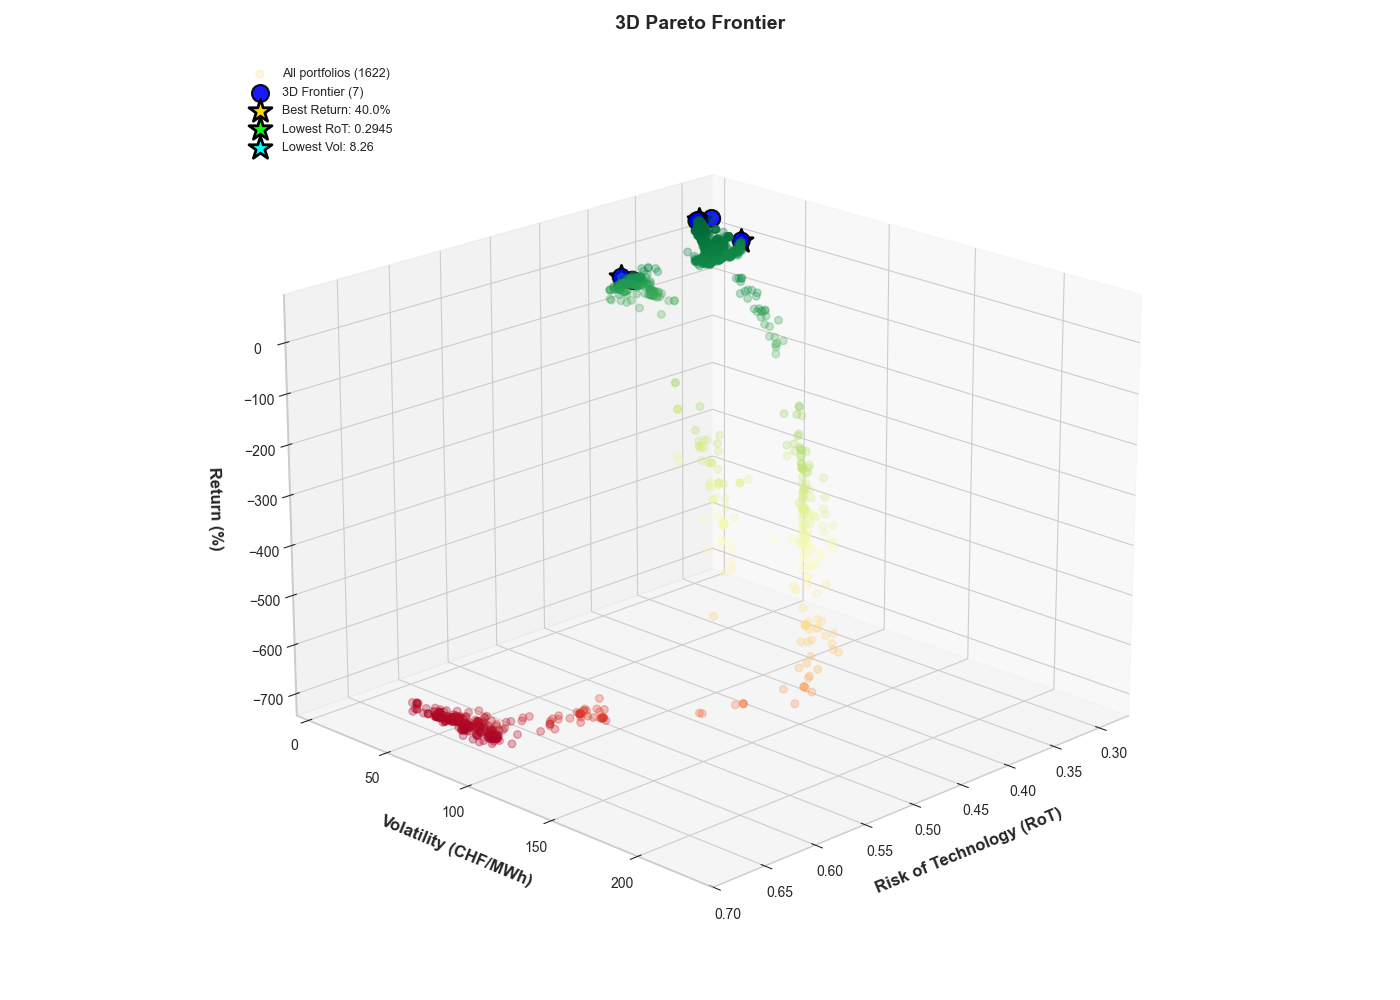


✅ 3D plot saved to: data/result_plots/pareto_frontier_3d.png

3D PARETO FRONTIER SUMMARY

Total portfolios explored: 1622
3D Frontier portfolios: 7

Frontier ranges:
  RoT:        [0.2945, 0.3920]
  Volatility: [8.26, 26.08] CHF/MWh
  Return:     [-44.47%, 40.01%]

Extreme points:
  ⭐ Best Return:      40.01% (RoT=0.3117, Vol=9.82)
  ⭐ Lowest RoT:       0.2945 (Return=3.47%, Vol=26.08)
  ⭐ Lowest Volatility: 8.26 CHF/MWh (Return=-33.07%, RoT=0.3920)

✅ 3D Frontier saved to: data/result_plots/multi_objective_results_final_frontier_3d.csv


In [8]:
# ============================================================================
# 3D PARETO FRONTIER VISUALIZATION (with Navigation Controls)
# ============================================================================
# Visualize the efficiency frontier in 3D: X=RoT, Y=Volatility, Z=Return
# Loads from saved files (works after kernel restart)
# Includes buttons for navigation and toggle for non-frontier portfolios

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from IPython.display import display

# Try to import ipywidgets for interactive controls
try:
    import ipywidgets as widgets
    from ipywidgets import Button, HBox, VBox, Checkbox, Layout, Label
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("⚠️ ipywidgets not installed. Run: pip install ipywidgets")
    print("   Navigation buttons will not be available.")

# Enable interactive plots
try:
    get_ipython().run_line_magic('matplotlib', 'widget')
    interactive_mode = True
    print("✅ Interactive mode enabled")
except:
    try:
        get_ipython().run_line_magic('matplotlib', 'notebook')
        interactive_mode = True
        print("✅ Interactive mode enabled (notebook backend)")
    except:
        interactive_mode = False
        print("⚠️ Static plot mode - install ipympl for interactive: pip install ipympl")

# =============================================================================
# LOAD DATA FROM SAVED FILES
# =============================================================================
# File paths
all_results_path = "data/result_plots/multi_objective_results_final.csv"
frontier_path = "data/result_plots/multi_objective_results_final_frontier.csv"

# Check files exist
if not os.path.exists(all_results_path):
    raise FileNotFoundError(
        f"Results file not found: {all_results_path}\n"
        f"Please run the 'MULTI-OBJECTIVE FRONTIER EXPLORATION' cell first."
    )

# Load data
print("="*70)
print("3D PARETO FRONTIER VISUALIZATION")
print("="*70)
print()
print(f"📂 Loading data from saved files...")
all_df = pd.read_csv(all_results_path)
print(f"   All portfolios: {len(all_df)}")

if os.path.exists(frontier_path):
    frontier_df = pd.read_csv(frontier_path)
    print(f"   2D Frontier portfolios: {len(frontier_df)}")
else:
    frontier_df = None
    print("   2D Frontier file not found (will compute from data)")

# =============================================================================
# COMPUTE 3D PARETO FRONTIER
# =============================================================================
# A point is on the 3D frontier if no other point is better in ALL three:
# - Lower RoT (minimize)
# - Lower Volatility (minimize)  
# - Higher Return (maximize)

def find_3d_pareto_frontier(df):
    """Find points on the 3D Pareto frontier."""
    x = df['x_RoT'].values
    y = df['y_volatility'].values
    z = df['z_return'].values
    
    n = len(df)
    is_pareto = np.ones(n, dtype=bool)
    
    for i in range(n):
        if not is_pareto[i]:
            continue
        for j in range(n):
            if i == j or not is_pareto[j]:
                continue
            # Check if j dominates i (j is better in all dimensions)
            # Better = lower RoT, lower volatility, higher return
            if (x[j] <= x[i] and y[j] <= y[i] and z[j] >= z[i]) and \
               (x[j] < x[i] or y[j] < y[i] or z[j] > z[i]):
                is_pareto[i] = False
                break
    
    return df[is_pareto].copy()

# Compute 3D frontier
pareto_3d_df = find_3d_pareto_frontier(all_df)
print(f"   3D Frontier portfolios: {len(pareto_3d_df)}")
print()

# =============================================================================
# CREATE 3D VISUALIZATION WITH NAVIGATION CONTROLS
# =============================================================================
print("Creating 3D plot with navigation controls...")
print()

# Extract coordinates
x_all = all_df['x_RoT'].values
y_all = all_df['y_volatility'].values
z_all = all_df['z_return'].values

x_frontier = pareto_3d_df['x_RoT'].values
y_frontier = pareto_3d_df['y_volatility'].values
z_frontier = pareto_3d_df['z_return'].values

# Get extreme points
best_return_idx = pareto_3d_df['z_return'].idxmax()
best_return = pareto_3d_df.loc[best_return_idx]
best_rot_idx = pareto_3d_df['x_RoT'].idxmin()
best_rot = pareto_3d_df.loc[best_rot_idx]
best_vol_idx = pareto_3d_df['y_volatility'].idxmin()
best_vol = pareto_3d_df.loc[best_vol_idx]

# Current view state
view_state = {'elev': 20, 'azim': 45, 'show_all': True}

# Create figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

def draw_plot():
    """Draw or redraw the 3D plot."""
    ax.clear()
    
    # Plot all portfolios if toggle is on
    if view_state['show_all']:
        scatter_all = ax.scatter(
            x_all, y_all, z_all,
            c=z_all, cmap='RdYlGn', s=30, alpha=0.3,
            label=f'All portfolios ({len(all_df)})'
        )
    
    # Plot 3D frontier (always visible)
    ax.scatter(
        x_frontier, y_frontier, z_frontier,
        c='blue', s=150, alpha=0.9, edgecolors='black', linewidths=1.5,
        marker='o', label=f'3D Frontier ({len(pareto_3d_df)})'
    )
    
    # Highlight extreme points
    ax.scatter([best_return['x_RoT']], [best_return['y_volatility']], [best_return['z_return']],
               c='gold', s=300, marker='*', edgecolors='black', linewidths=2,
               label=f"Best Return: {best_return['z_return']:.1f}%", zorder=10)
    ax.scatter([best_rot['x_RoT']], [best_rot['y_volatility']], [best_rot['z_return']],
               c='lime', s=300, marker='*', edgecolors='black', linewidths=2,
               label=f"Lowest RoT: {best_rot['x_RoT']:.4f}", zorder=10)
    ax.scatter([best_vol['x_RoT']], [best_vol['y_volatility']], [best_vol['z_return']],
               c='cyan', s=300, marker='*', edgecolors='black', linewidths=2,
               label=f"Lowest Vol: {best_vol['y_volatility']:.2f}", zorder=10)
    
    # Labels and title
    ax.set_xlabel('Risk of Technology (RoT)', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Volatility (CHF/MWh)', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_zlabel('Return (%)', fontsize=12, fontweight='bold', labelpad=10)
    title = '3D Pareto Frontier' + (' (Frontier Only)' if not view_state['show_all'] else '')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    ax.legend(loc='upper left', fontsize=9)
    ax.view_init(elev=view_state['elev'], azim=view_state['azim'])
    ax.grid(True, alpha=0.3)
    fig.canvas.draw_idle()

# Draw initial plot
draw_plot()

# =============================================================================
# NAVIGATION BUTTONS (if ipywidgets available)
# =============================================================================
if HAS_WIDGETS:
    # Rotation/zoom steps
    ROT_STEP = 15
    ELEV_STEP = 10
    ZOOM_FACTOR = 1.2
    
    # Store initial axis limits for zoom reference
    view_state['xlim'] = ax.get_xlim3d()
    view_state['ylim'] = ax.get_ylim3d()
    view_state['zlim'] = ax.get_zlim3d()
    view_state['zoom'] = 1.0
    
    # Create buttons
    btn_left = Button(description='← Rotate Left', layout=Layout(width='120px'))
    btn_right = Button(description='Rotate Right →', layout=Layout(width='120px'))
    btn_up = Button(description='↑ Tilt Up', layout=Layout(width='100px'))
    btn_down = Button(description='↓ Tilt Down', layout=Layout(width='100px'))
    btn_zoom_in = Button(description='🔍+ Zoom In', layout=Layout(width='100px'))
    btn_zoom_out = Button(description='🔍− Zoom Out', layout=Layout(width='100px'))
    btn_reset = Button(description='⟲ Reset View', layout=Layout(width='100px'), button_style='warning')
    
    # Toggle for showing all portfolios
    toggle_all = Checkbox(value=True, description='Show all portfolios', indent=False,
                          layout=Layout(width='180px'))
    
    # Button callbacks
    def rotate_left(b):
        view_state['azim'] = (view_state['azim'] - ROT_STEP) % 360
        ax.view_init(elev=view_state['elev'], azim=view_state['azim'])
        fig.canvas.draw_idle()
    
    def rotate_right(b):
        view_state['azim'] = (view_state['azim'] + ROT_STEP) % 360
        ax.view_init(elev=view_state['elev'], azim=view_state['azim'])
        fig.canvas.draw_idle()
    
    def tilt_up(b):
        view_state['elev'] = min(90, view_state['elev'] + ELEV_STEP)
        ax.view_init(elev=view_state['elev'], azim=view_state['azim'])
        fig.canvas.draw_idle()
    
    def tilt_down(b):
        view_state['elev'] = max(-90, view_state['elev'] - ELEV_STEP)
        ax.view_init(elev=view_state['elev'], azim=view_state['azim'])
        fig.canvas.draw_idle()
    
    def apply_zoom():
        """Apply current zoom level to axes."""
        z = view_state['zoom']
        # Compute center and range for each axis
        for lim, setter in [(view_state['xlim'], ax.set_xlim3d),
                            (view_state['ylim'], ax.set_ylim3d),
                            (view_state['zlim'], ax.set_zlim3d)]:
            center = (lim[0] + lim[1]) / 2
            half_range = (lim[1] - lim[0]) / 2 / z
            setter(center - half_range, center + half_range)
        fig.canvas.draw_idle()
    
    def zoom_in(b):
        view_state['zoom'] = min(10.0, view_state['zoom'] * ZOOM_FACTOR)
        apply_zoom()
    
    def zoom_out(b):
        view_state['zoom'] = max(0.2, view_state['zoom'] / ZOOM_FACTOR)
        apply_zoom()
    
    def reset_view(b):
        view_state['elev'] = 20
        view_state['azim'] = 45
        view_state['zoom'] = 1.0
        ax.view_init(elev=view_state['elev'], azim=view_state['azim'])
        ax.set_xlim3d(view_state['xlim'])
        ax.set_ylim3d(view_state['ylim'])
        ax.set_zlim3d(view_state['zlim'])
        fig.canvas.draw_idle()
    
    def toggle_portfolios(change):
        view_state['show_all'] = change['new']
        draw_plot()
        # Reapply zoom after redraw
        apply_zoom()
    
    # Connect callbacks
    btn_left.on_click(rotate_left)
    btn_right.on_click(rotate_right)
    btn_up.on_click(tilt_up)
    btn_down.on_click(tilt_down)
    btn_zoom_in.on_click(zoom_in)
    btn_zoom_out.on_click(zoom_out)
    btn_reset.on_click(reset_view)
    toggle_all.observe(toggle_portfolios, names='value')
    
    # Layout
    rotation_box = HBox([btn_left, btn_right], layout=Layout(justify_content='center'))
    tilt_box = HBox([btn_up, btn_down], layout=Layout(justify_content='center'))
    zoom_box = HBox([btn_zoom_in, btn_zoom_out], layout=Layout(justify_content='center'))
    controls = VBox([
        Label('🎮 Navigation Controls:'),
        rotation_box,
        tilt_box,
        zoom_box,
        HBox([btn_reset, toggle_all], layout=Layout(justify_content='center', gap='20px'))
    ], layout=Layout(padding='10px', border='1px solid #ccc', margin='10px 0'))
    
    display(controls)
    print("Use buttons above to navigate.")
else:
    print("Navigation buttons not available (ipywidgets not installed).")
    print("Use mouse to rotate: click and drag.")

plt.tight_layout()
plt.show()

# Save figure
save_path = 'data/result_plots/pareto_frontier_3d.png'
fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n✅ 3D plot saved to: {save_path}")

# =============================================================================
# PRINT FRONTIER SUMMARY
# =============================================================================
print()
print("="*70)
print("3D PARETO FRONTIER SUMMARY")
print("="*70)
print()
print(f"Total portfolios explored: {len(all_df)}")
print(f"3D Frontier portfolios: {len(pareto_3d_df)}")
print()
print("Frontier ranges:")
print(f"  RoT:        [{pareto_3d_df['x_RoT'].min():.4f}, {pareto_3d_df['x_RoT'].max():.4f}]")
print(f"  Volatility: [{pareto_3d_df['y_volatility'].min():.2f}, {pareto_3d_df['y_volatility'].max():.2f}] CHF/MWh")
print(f"  Return:     [{pareto_3d_df['z_return'].min():.2f}%, {pareto_3d_df['z_return'].max():.2f}%]")
print()
print("Extreme points:")
print(f"  ⭐ Best Return:      {best_return['z_return']:.2f}% (RoT={best_return['x_RoT']:.4f}, Vol={best_return['y_volatility']:.2f})")
print(f"  ⭐ Lowest RoT:       {best_rot['x_RoT']:.4f} (Return={best_rot['z_return']:.2f}%, Vol={best_rot['y_volatility']:.2f})")
print(f"  ⭐ Lowest Volatility: {best_vol['y_volatility']:.2f} CHF/MWh (Return={best_vol['z_return']:.2f}%, RoT={best_vol['x_RoT']:.4f})")
print("="*70)

# Save 3D frontier to CSV
frontier_3d_path = "data/result_plots/multi_objective_results_final_frontier_3d.csv"
pareto_3d_df.to_csv(frontier_3d_path, index=False)
print(f"\n✅ 3D Frontier saved to: {frontier_3d_path}")


In [9]:
# ============================================================================
# PORTFOLIO DETAILED ANALYSIS - Full Year Simulation
# ============================================================================
# Select a portfolio from the frontier and run comprehensive analysis:
# - Storage evolution over the year
# - Stacked production by source
# - Financial analysis (spot market)
# - Energy surplus/deficit
# - Cost/volume pie chart
# - Capacity limits status

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import json
import os
from datetime import datetime, timedelta
from IPython.display import display, HTML

# Import required modules
from optimization import evaluate_portfolio_full_year, Individual, create_ppu_dictionary
from config import Config, DEFAULT_CONFIG
from ppu_framework import load_all_ppu_data, Portfolio

try:
    import ipywidgets as widgets
    from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, IntSlider
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("⚠️ ipywidgets not installed. Run: pip install ipywidgets")

# =============================================================================
# LOAD FRONTIER PORTFOLIOS
# =============================================================================
frontier_path = "data/result_plots/multi_objective_results_final_frontier_3d.csv"
if not os.path.exists(frontier_path):
    frontier_path = "data/result_plots/multi_objective_results_final_frontier.csv"
if not os.path.exists(frontier_path):
    raise FileNotFoundError("No frontier file found. Run the multi-objective exploration first.")

frontier_df = pd.read_csv(frontier_path)
print(f"✅ Loaded {len(frontier_df)} frontier portfolios")

# Create dropdown options with descriptive names
dropdown_options = []
for idx, row in frontier_df.iterrows():
    label = f"#{idx}: RoT={row['x_RoT']:.4f}, Vol={row['y_volatility']:.1f}, Return={row['z_return']:.1f}%"
    dropdown_options.append((label, idx))

# Load config and PPU data
config = DEFAULT_CONFIG
_, _, ppu_definitions = load_all_ppu_data(config)

# =============================================================================
# ANALYSIS FUNCTIONS
# =============================================================================

def run_portfolio_analysis(portfolio_dict: dict, config: Config):
    """Run full year simulation and return results."""
    # Create Portfolio object
    portfolio = Portfolio(ppu_counts=portfolio_dict)
    individual = Individual(portfolio=portfolio)
    
    # Run full year evaluation (verbose=False to reduce output)
    print("Running full year simulation (8760 hours)...")
    results = evaluate_portfolio_full_year(individual, config, verbose=False)
    print("✅ Simulation complete!")
    return results

def plot_storage_evolution(results, figsize=(16, 10)):
    """Plot storage state of charge over the year."""
    storage_soc = results.storage_soc
    if not storage_soc:
        print("No storage data available")
        return None
    
    # Create time axis (2024)
    hours = np.arange(len(results.demand))
    dates = [datetime(2024, 1, 1) + timedelta(hours=int(h)) for h in hours]
    
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # Top: Large storages (TWh scale)
    ax1 = axes[0]
    large_storages = ['Lake', 'Fuel Tank', 'H2 UG 200bar', 'CH4 200bar']
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i, (name, soc) in enumerate(storage_soc.items()):
        if name in large_storages and np.any(soc > 0):
            ax1.plot(dates, soc / 1e6, label=f'{name}', linewidth=1.5, color=colors[i])
    
    ax1.set_ylabel('State of Charge (TWh)', fontsize=12)
    ax1.set_title('Large Storage Evolution (2024)', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    
    # Bottom: Smaller storages (GWh scale)
    ax2 = axes[1]
    small_storages = [n for n in storage_soc.keys() if n not in large_storages]
    
    for i, name in enumerate(small_storages):
        soc = storage_soc[name]
        if np.any(soc > 0):
            ax2.plot(dates, soc / 1e3, label=f'{name}', linewidth=1.5, color=colors[i])
    
    ax2.set_xlabel('Month', fontsize=12)
    ax2.set_ylabel('State of Charge (GWh)', fontsize=12)
    ax2.set_title('Smaller Storage Evolution (2024)', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.tight_layout()
    return fig

def plot_stacked_production(results, time_range='year', period_idx=0, figsize=(16, 8)):
    """
    Plot stacked area chart of production by source.
    
    Args:
        results: Full year results
        time_range: 'week', 'month', '6months', or 'year'
        period_idx: Index of period (week 0-51, month 0-11, half 0-1)
        figsize: Figure size
    """
    ppu_production = results.ppu_production
    if not ppu_production:
        print("No PPU production data available")
        return None
    
    n_hours = len(results.demand)
    
    # Determine time slice based on range
    if time_range == 'week':
        start_h = period_idx * 168
        end_h = min(start_h + 168, n_hours)
        title_suffix = f" - Week {period_idx + 1}"
        resample = False  # Hourly for week
    elif time_range == 'month':
        # Approximate month boundaries
        days_per_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        start_day = sum(days_per_month[:period_idx])
        end_day = start_day + days_per_month[period_idx]
        start_h = start_day * 24
        end_h = min(end_day * 24, n_hours)
        month_names = ['January', 'February', 'March', 'April', 'May', 'June',
                       'July', 'August', 'September', 'October', 'November', 'December']
        title_suffix = f" - {month_names[period_idx]}"
        resample = False  # Hourly for month
    elif time_range == '6months':
        if period_idx == 0:
            start_h, end_h = 0, 4344  # Jan 1 - Jun 30 (~181 days)
            title_suffix = " - First Half (Jan-Jun)"
        else:
            start_h, end_h = 4344, n_hours
            title_suffix = " - Second Half (Jul-Dec)"
        resample = True  # Daily for 6 months
    else:  # year
        start_h, end_h = 0, n_hours
        title_suffix = " - Full Year"
        resample = True  # Daily for full year
    
    # Prepare production data
    prod_data = {}
    for name, prod in ppu_production.items():
        if np.sum(prod) > 0:
            slice_data = prod[start_h:end_h]
            if resample and len(slice_data) >= 24:
                # Resample to daily average
                n_full_days = len(slice_data) // 24
                daily_prod = slice_data[:n_full_days*24].reshape(n_full_days, 24).mean(axis=1)
                prod_data[name] = daily_prod
            else:
                prod_data[name] = slice_data
    
    if not prod_data:
        print("No production data to plot")
        return None
    
    # Create dates for x-axis
    n_points = len(list(prod_data.values())[0])
    if resample:
        base_day = start_h // 24
        dates = [datetime(2024, 1, 1) + timedelta(days=base_day + d) for d in range(n_points)]
    else:
        dates = [datetime(2024, 1, 1) + timedelta(hours=start_h + h) for h in range(n_points)]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Sort by total production
    sorted_names = sorted(prod_data.keys(), key=lambda x: np.sum(prod_data[x]), reverse=True)
    
    # Create stacked area
    colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_names)))
    bottom = np.zeros(len(dates))
    
    for i, name in enumerate(sorted_names):
        values = prod_data[name] / 1000  # Convert to GW
        ax.fill_between(dates, bottom, bottom + values, label=name, alpha=0.8, color=colors[i])
        bottom += values
    
    # Add demand line
    demand_slice = results.demand[start_h:end_h]
    if resample and len(demand_slice) >= 24:
        n_full_days = len(demand_slice) // 24
        demand_plot = demand_slice[:n_full_days*24].reshape(n_full_days, 24).mean(axis=1) / 1000
    else:
        demand_plot = demand_slice / 1000
    ax.plot(dates, demand_plot, 'k--', linewidth=2, label='Demand')
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Power (GW)', fontsize=12)
    ax.set_title(f'Production by Source{title_suffix}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis based on time range
    if time_range == 'week':
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))
    elif time_range == 'month':
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        ax.set_xlabel('Day of Month', fontsize=12)
    else:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.tight_layout()
    return fig

def plot_financial_analysis(results, figsize=(16, 12)):
    """Plot financial analysis - spot market activity."""
    hours = np.arange(len(results.demand))
    dates = [datetime(2024, 1, 1) + timedelta(hours=int(h)) for h in hours]
    
    # Daily aggregation
    n_days = len(results.demand) // 24
    daily_bought = results.spot_bought[:n_days*24].reshape(n_days, 24).sum(axis=1) / 1000  # GWh
    daily_sold = results.spot_sold[:n_days*24].reshape(n_days, 24).sum(axis=1) / 1000
    daily_prices = results.spot_prices[:n_days*24].reshape(n_days, 24).mean(axis=1)
    daily_deficit = results.deficit[:n_days*24].reshape(n_days, 24).sum(axis=1) / 1000
    daily_surplus = results.surplus[:n_days*24].reshape(n_days, 24).sum(axis=1) / 1000
    
    day_dates = [datetime(2024, 1, 1) + timedelta(days=int(d)) for d in range(n_days)]
    
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    # Plot 1: Spot buying/selling
    ax1 = axes[0]
    ax1.bar(day_dates, daily_bought, color='red', alpha=0.7, label='Bought from Spot')
    ax1.bar(day_dates, -daily_sold, color='green', alpha=0.7, label='Sold to Spot')
    ax1.axhline(0, color='black', linewidth=0.5)
    ax1.set_ylabel('Energy (GWh/day)', fontsize=12)
    ax1.set_title('Spot Market Activity', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    # Plot 2: Spot prices with buy/sell overlay
    ax2 = axes[1]
    ax2.plot(day_dates, daily_prices, 'b-', linewidth=1, label='Spot Price')
    ax2.fill_between(day_dates, 0, daily_prices, where=(daily_bought > 0), 
                     color='red', alpha=0.3, label='Buying Period')
    ax2.fill_between(day_dates, 0, daily_prices, where=(daily_sold > 0), 
                     color='green', alpha=0.3, label='Selling Period')
    ax2.set_ylabel('Price (CHF/MWh)', fontsize=12)
    ax2.set_title('Spot Price & Trading Periods', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    # Plot 3: Deficit/Surplus
    ax3 = axes[2]
    ax3.fill_between(day_dates, 0, daily_deficit, color='red', alpha=0.7, label='Energy Deficit')
    ax3.fill_between(day_dates, 0, -daily_surplus, color='green', alpha=0.7, label='Energy Surplus')
    ax3.axhline(0, color='black', linewidth=0.5)
    ax3.set_xlabel('Month', fontsize=12)
    ax3.set_ylabel('Energy (GWh/day)', fontsize=12)
    ax3.set_title('Energy Balance (Surplus/Deficit)', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    plt.tight_layout()
    return fig

def plot_cost_volume_pie(results, portfolio_dict, ppu_definitions, figsize=(14, 6)):
    """Plot pie charts for production volume and cost by PPU."""
    ppu_production = results.ppu_production
    
    # Calculate volumes and costs
    volumes = {}
    costs = {}
    
    for ppu_name, prod in ppu_production.items():
        vol_twh = np.sum(prod) / 1e6
        if vol_twh > 0.01:  # Only significant producers
            volumes[ppu_name] = vol_twh
            # Get cost per MWh
            if ppu_name in ppu_definitions:
                cost_per_mwh = ppu_definitions[ppu_name].cost_per_mwh
            else:
                cost_per_mwh = 50.0  # Default
            costs[ppu_name] = vol_twh * cost_per_mwh * 1e6 / 1e9  # Billion CHF
    
    if not volumes:
        print("No production data for pie chart")
        return None
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Sort by volume
    sorted_ppus = sorted(volumes.keys(), key=lambda x: volumes[x], reverse=True)
    vol_values = [volumes[p] for p in sorted_ppus]
    cost_values = [costs[p] for p in sorted_ppus]
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_ppus)))
    
    # Volume pie
    ax1 = axes[0]
    wedges1, texts1, autotexts1 = ax1.pie(
        vol_values, labels=sorted_ppus, autopct='%1.1f%%',
        colors=colors, startangle=90, pctdistance=0.75
    )
    ax1.set_title(f'Production Volume\n(Total: {sum(vol_values):.1f} TWh)', fontsize=14, fontweight='bold')
    
    # Cost pie
    ax2 = axes[1]
    wedges2, texts2, autotexts2 = ax2.pie(
        cost_values, labels=sorted_ppus, autopct='%1.1f%%',
        colors=colors, startangle=90, pctdistance=0.75
    )
    ax2.set_title(f'Production Cost\n(Total: {sum(cost_values):.2f} B CHF)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

def display_capacity_limits(portfolio_dict, config):
    """Display capacity limits status for each PPU."""
    bounds = config.ppu.PORTFOLIO_BOUNDS
    caps = config.ppu.PROGRESSIVE_COST_CAPS
    
    print("\n" + "="*70)
    print("CAPACITY LIMITS STATUS")
    print("="*70)
    print(f"{'PPU':<15} {'Units':>8} {'Soft Cap':>10} {'Hard Cap':>10} {'Status':<20}")
    print("-"*70)
    
    for ppu, count in sorted(portfolio_dict.items(), key=lambda x: -x[1]):
        if count == 0:
            continue
        
        hard_cap = bounds.get(ppu, (0, 1000))[1]
        soft_cap = caps.get(ppu, {}).get('soft_cap', hard_cap)
        
        # Determine status
        if count >= hard_cap:
            status = "⛔ HARD CAP REACHED"
        elif count >= soft_cap:
            over_soft = count - soft_cap
            factor = caps.get(ppu, {}).get('factor', 0)
            extra_cost = over_soft * factor * 100
            status = f"⚠️  Soft cap +{extra_cost:.1f}%"
        else:
            remaining = soft_cap - count
            status = f"✅ {remaining} units to soft cap"
        
        print(f"{ppu:<15} {count:>8} {soft_cap:>10} {hard_cap:>10} {status:<20}")
    
    print("="*70)

def display_summary_metrics(results, portfolio_dict):
    """Display key summary metrics."""
    print("\n" + "="*70)
    print("ANNUAL PERFORMANCE SUMMARY")
    print("="*70)
    
    # Energy metrics
    total_demand = np.sum(results.demand) / 1e6
    total_production = np.sum(results.total_production) / 1e6
    total_bought = np.sum(results.spot_bought) / 1e6
    total_sold = np.sum(results.spot_sold) / 1e6
    
    print(f"\n📊 Energy Balance:")
    print(f"   Total Demand:      {total_demand:>10.2f} TWh")
    print(f"   Total Production:  {total_production:>10.2f} TWh")
    print(f"   Spot Bought:       {total_bought:>10.2f} TWh")
    print(f"   Spot Sold:         {total_sold:>10.2f} TWh")
    print(f"   Net Import:        {(total_bought - total_sold):>10.2f} TWh")
    
    # DIAGNOSTIC: Check raw renewable vs demand (BEFORE storage/dispatch)
    if hasattr(results, 'renewable_production') and results.renewable_production is not None:
        renewable = results.renewable_production
        demand = results.demand
        diff = renewable - demand  # Positive = surplus, Negative = deficit
        
        print(f"\n🔍 RAW RENEWABLE VS DEMAND (before storage/dispatch):")
        print(f"   ─────────────────────────────────────────────────────")
        print(f"   Total Renewable:   {np.sum(renewable)/1e6:>10.2f} TWh")
        print(f"   Total Demand:      {np.sum(demand)/1e6:>10.2f} TWh")
        print(f"   Gap (Dem-Ren):     {(np.sum(demand)-np.sum(renewable))/1e6:>10.2f} TWh")
        print(f"   ─────────────────────────────────────────────────────")
        print(f"   Max Renewable:     {np.max(renewable):>10.2f} MW ({np.max(renewable)/1000:.2f} GW)")
        print(f"   Mean Renewable:    {np.mean(renewable):>10.2f} MW ({np.mean(renewable)/1000:.2f} GW)")
        print(f"   Max Demand:        {np.max(demand):>10.2f} MW ({np.max(demand)/1000:.2f} GW)")
        print(f"   Mean Demand:       {np.mean(demand):>10.2f} MW ({np.mean(demand)/1000:.2f} GW)")
        print(f"   ─────────────────────────────────────────────────────")
        print(f"   Hours Ren > Dem:   {np.sum(diff > 0):>10} h  ({100*np.sum(diff > 0)/len(diff):.1f}%)")
        print(f"   Hours Ren < Dem:   {np.sum(diff < 0):>10} h  ({100*np.sum(diff < 0)/len(diff):.1f}%)")
        print(f"   Hours Ren = Dem:   {np.sum(diff == 0):>10} h")
        print(f"   ─────────────────────────────────────────────────────")
        print(f"   Max Surplus (raw): {np.max(diff):>10.2f} MW")
        print(f"   Max Deficit (raw): {-np.min(diff):>10.2f} MW")
        print(f"   ─────────────────────────────────────────────────────")
        
        # Calculate how much storage/dispatch was needed
        gap_twh = (np.sum(demand) - np.sum(renewable)) / 1e6
        renewable_share = np.sum(renewable) / np.sum(demand) * 100
        
        print(f"\n📊 RENEWABLE COVERAGE:")
        print(f"   Renewable share:   {renewable_share:>10.1f}%")
        print(f"   Shortfall:         {gap_twh:>10.2f} TWh (filled by storage/dispatch)")
        
        if renewable_share < 50:
            print(f"\n   ⚠️  WARNING: Renewable < 50% of demand!")
            print(f"   The portfolio relies heavily on storage/dispatchable.")
            print(f"   Consider: More PV/Wind units, or check wind data quality.")
    
    # Financial metrics
    buy_cost = np.sum(results.spot_bought * results.spot_prices) / 1e9
    sell_revenue = np.sum(results.spot_sold * results.spot_prices) / 1e9
    net_spot = buy_cost - sell_revenue
    
    print(f"\n💰 Spot Market Financials:")
    print(f"   Buy Cost:          {buy_cost:>10.2f} B CHF")
    print(f"   Sell Revenue:      {sell_revenue:>10.2f} B CHF")
    print(f"   Net Spot Cost:     {net_spot:>10.2f} B CHF")
    
    # Deficit/Surplus
    hours_deficit = np.sum(results.deficit > 0)
    hours_surplus = np.sum(results.surplus > 0)
    max_deficit = np.max(results.deficit) / 1000
    
    print(f"\n⚡ Grid Balance:")
    print(f"   Hours in Deficit:  {hours_deficit:>10} h ({hours_deficit/87.6:.1f}%)")
    print(f"   Hours in Surplus:  {hours_surplus:>10} h ({hours_surplus/87.6:.1f}%)")
    print(f"   Peak Deficit:      {max_deficit:>10.2f} GW")
    
    # Aviation fuel
    if hasattr(results, 'aviation_fuel_consumed_mwh'):
        consumed = results.aviation_fuel_consumed_mwh / 1e6
        required = 23.0  # TWh/year
        import_cost = results.aviation_fuel_import_cost_chf / 1e9 if hasattr(results, 'aviation_fuel_import_cost_chf') else 0
        print(f"\n✈️  Aviation Fuel (always imported at 67 CHF/MWh):")
        print(f"   Required:          {required:>10.2f} TWh/year")
        print(f"   Consumed:          {consumed:>10.2f} TWh")
        print(f"   Import Cost:       {import_cost:>10.2f} B CHF")
        print(f"   Constraint Met:    {'✅ Yes' if results.aviation_fuel_constraint_met else '❌ No'}")
    
    print("="*70)

# =============================================================================
# INTERACTIVE INTERFACE
# =============================================================================
if HAS_WIDGETS:
    # Create widgets
    portfolio_dropdown = Dropdown(
        options=dropdown_options,
        description='Portfolio:',
        layout=Layout(width='500px'),
        style={'description_width': '80px'}
    )
    
    # Time range options
    time_range_dropdown = Dropdown(
        options=[
            ('1 Week', 'week'),
            ('1 Month', 'month'),
            ('6 Months', '6months'),
            ('Full Year', 'year')
        ],
        value='year',
        description='Time Range:',
        layout=Layout(width='200px'),
        style={'description_width': '80px'}
    )
    
    week_slider = IntSlider(
        value=0, min=0, max=51,
        description='Week:',
        layout=Layout(width='300px'),
        style={'description_width': '50px'}
    )
    
    month_slider = IntSlider(
        value=0, min=0, max=11,
        description='Month:',
        layout=Layout(width='300px'),
        style={'description_width': '50px'}
    )
    
    half_dropdown = Dropdown(
        options=[('First Half (Jan-Jun)', 0), ('Second Half (Jul-Dec)', 1)],
        value=0,
        description='Period:',
        layout=Layout(width='250px'),
        style={'description_width': '60px'}
    )
    
    analyze_btn = Button(
        description='🔍 Analyze Portfolio',
        button_style='success',
        layout=Layout(width='200px')
    )
    
    output_area = Output()
    
    # Store results globally
    current_results = {'data': None, 'portfolio': None}
    
    def get_period_index():
        """Get the period index based on selected time range."""
        tr = time_range_dropdown.value
        if tr == 'week':
            return week_slider.value
        elif tr == 'month':
            return month_slider.value
        elif tr == '6months':
            return half_dropdown.value
        return 0
    
    def on_analyze(b):
        with output_area:
            output_area.clear_output(wait=True)
            
            # Get selected portfolio
            idx = portfolio_dropdown.value
            row = frontier_df.iloc[idx]
            portfolio_dict = json.loads(row['portfolio_dict'])
            
            print(f"Selected Portfolio #{idx}:")
            print(f"  RoT: {row['x_RoT']:.4f}")
            print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
            print(f"  Return: {row['z_return']:.2f}%")
            print()
            
            # Run analysis
            results = run_portfolio_analysis(portfolio_dict, config)
            current_results['data'] = results
            current_results['portfolio'] = portfolio_dict
            
            # Display summary
            display_summary_metrics(results, portfolio_dict)
            
            # Display capacity limits
            display_capacity_limits(portfolio_dict, config)
            
            # Plot 1: Storage Evolution
            print("\n📈 Storage Evolution:")
            fig1 = plot_storage_evolution(results)
            if fig1:
                plt.show()
            
            # Plot 2: Stacked Production (selected time range)
            tr = time_range_dropdown.value
            period_idx = get_period_index()
            print(f"\n📊 Production by Source:")
            fig2 = plot_stacked_production(results, time_range=tr, period_idx=period_idx)
            if fig2:
                plt.show()
            
            # Plot 3: Financial Analysis
            print("\n💹 Financial Analysis:")
            fig3 = plot_financial_analysis(results)
            if fig3:
                plt.show()
            
            # Plot 4: Cost/Volume Pie
            print("\n🥧 Cost & Volume Distribution:")
            fig4 = plot_cost_volume_pie(results, portfolio_dict, ppu_definitions)
            if fig4:
                plt.show()
    
    def on_time_change(change):
        """Callback when time range or period selector changes."""
        if current_results['data'] is not None:
            with output_area:
                tr = time_range_dropdown.value
                period_idx = get_period_index()
                print(f"\n📊 Production by Source (updated view):")
                fig = plot_stacked_production(current_results['data'], time_range=tr, period_idx=period_idx)
                if fig:
                    plt.show()
    
    analyze_btn.on_click(on_analyze)
    week_slider.observe(on_time_change, names='value')
    month_slider.observe(on_time_change, names='value')
    half_dropdown.observe(on_time_change, names='value')
    time_range_dropdown.observe(on_time_change, names='value')
    
    # Period selector container (changes based on time range)
    period_box = HBox([
        week_slider,
        month_slider, 
        half_dropdown
    ])
    
    # Layout
    controls = VBox([
        Label('🔬 Portfolio Detailed Analysis', layout=Layout(margin='0 0 10px 0')),
        HBox([portfolio_dropdown, analyze_btn]),
        HBox([time_range_dropdown, Label('  Period: '), week_slider, month_slider, half_dropdown]),
    ], layout=Layout(padding='10px', border='1px solid #ccc', margin='10px 0'))
    
    display(controls)
    display(output_area)
    
    print("\n👆 Select a portfolio and click 'Analyze Portfolio' to see full year results.")
    print("   Then use Time Range and period selectors to view different time windows.")
else:
    print("Interactive widgets not available. Install ipywidgets:")
    print("  pip install ipywidgets")


✅ Loaded 7 frontier portfolios


Output()


👆 Select a portfolio and click 'Analyze Portfolio' to see full year results.
   Then use Time Range and period selectors to view different time windows.


✅ Efficiency frontier plot saved to: data/result_plots/efficiency_frontier_multi_objective.png


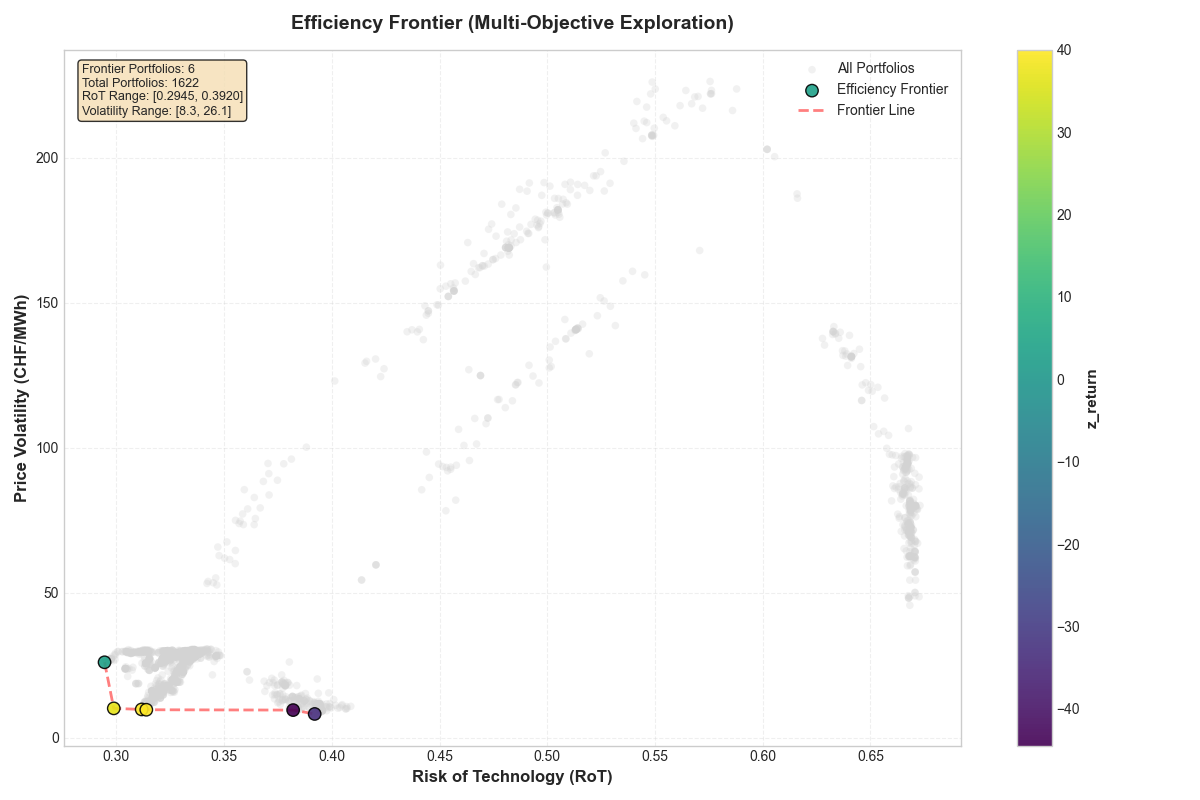

FRONTIER COMPARISON

Multi-Objective Exploration:
  Portfolios: 1622
  Frontier:   6
  RoT range:  [0.2945, 0.3920]
  Vol range:  [8.26, 26.08]

Single-Objective (Cost) Exploration:


In [25]:
# ============================================================================
# VISUALIZE MULTI-OBJECTIVE FRONTIER
# ============================================================================

# Plot the efficiency frontier from multi-objective exploration
fig_mo = plot_efficiency_frontier(
    all_df_mo, pareto_df_mo,
    x_col='x_RoT',
    y_col='y_volatility',
    x_label='Risk of Technology (RoT)',
    y_label='Price Volatility (CHF/MWh)',
    title='Efficiency Frontier (Multi-Objective Exploration)',
    color_by='z_return',
    save_path='data/result_plots/efficiency_frontier_multi_objective.png'
)

plt.show()

# Compare frontier coverage
print("="*60)
print("FRONTIER COMPARISON")
print("="*60)
print()
print("Multi-Objective Exploration:")
print(f"  Portfolios: {len(all_df_mo)}")
print(f"  Frontier:   {len(pareto_df_mo)}")
print(f"  RoT range:  [{pareto_df_mo['x_RoT'].min():.4f}, {pareto_df_mo['x_RoT'].max():.4f}]")
print(f"  Vol range:  [{pareto_df_mo['y_volatility'].min():.2f}, {pareto_df_mo['y_volatility'].max():.2f}]")

# If we have results from the single-objective approach, compare
try:
    print()
    print("Single-Objective (Cost) Exploration:")
    print(f"  Portfolios: {len(all_results_df)}")
    print(f"  Frontier:   {len(pareto_frontier_df)}")
    print(f"  RoT range:  [{pareto_frontier_df['x_RoT'].min():.4f}, {pareto_frontier_df['x_RoT'].max():.4f}]")
    print(f"  Vol range:  [{pareto_frontier_df['y_volatility'].min():.2f}, {pareto_frontier_df['y_volatility'].max():.2f}]")
except:
    pass


In [26]:
# ============================================================================
# SYSTEM CONFIGURATION SUMMARY
# ============================================================================
# Display comprehensive system configuration:
# - Primary resources and associated countries
# - Component efficiency, cost, and risk
# - All PPUs: cost, efficiency, risk, price escalation
# - All storage units: dimensioning, limitations, scaling
# Note: All imports are in the first cell - no need to re-import here

# Load all data
print("Loading system data...")
cost_df, constructs_df, ppu_definitions = load_all_ppu_data(config)
risk_calc = RiskCalculator(config)

print("\n" + "="*80)
print("SYSTEM CONFIGURATION SUMMARY")
print("="*80)

# ============================================================================
# 1. PRIMARY RESOURCES AND ASSOCIATED COUNTRIES
# ============================================================================
print("\n" + "="*80)
print("1. PRIMARY RESOURCES AND ASSOCIATED COUNTRIES")
print("="*80)

# Get country-resource data
country_resource_df = risk_calc.country_resource_df
# Group by resource - get count and unique countries
resource_groups = country_resource_df.groupby('Resource')['Country']
resource_counts = pd.DataFrame({
    'Resource': resource_groups.count().index,
    'Country_Count': resource_groups.count().values,
    'Countries': [list(group.unique()) for name, group in resource_groups]
})

# Sort by risk (descending - highest risk first)
resource_counts['Risk'] = resource_counts['Country_Count'].apply(lambda x: np.sqrt(1.0 / x))
resource_counts = resource_counts.sort_values('Risk', ascending=False)

print(f"\nTotal resources tracked: {len(resource_counts)}")
print("\nAll resources by risk (highest risk first):")
print("-" * 100)
print(f"{'Resource':<50} {'Countries':<8} {'Risk':<10} {'All Countries':<50}")
print("-" * 100)

for _, row in resource_counts.iterrows():
    countries = row['Countries']
    all_countries_str = ', '.join(countries)  # Show all countries, not just sample
    print(f"{row['Resource']:<50} {row['Country_Count']:<8} {row['Risk']:<10.4f} {all_countries_str:<50}")

# ============================================================================
# 2. COMPONENTS: EFFICIENCY, COST, AND RISK
# ============================================================================
print("\n" + "="*80)
print("2. COMPONENTS: EFFICIENCY, COST PER kWh, AND RISK")
print("="*80)

# Get all unique components from PPU definitions
all_components = set()
for ppu_def in ppu_definitions.values():
    all_components.update(ppu_def.components)

# Build component summary
component_data = []
for component in sorted(all_components):
    # Get efficiency and cost from cost table
    if component in cost_df.index:
        row = cost_df.loc[component]
        efficiency = row.get('efficiency', 1.0)
        cost_chf_per_kwh = row.get('cost', 0.0)
    else:
        efficiency = 1.0
        cost_chf_per_kwh = 0.0
    
    # Get component risk
    comp_risk = risk_calc.component_to_resources.get(component, [])
    if comp_risk:
        # Calculate risk using power mean
        resource_risks = [risk_calc.resource_risks.get(r, 1.0) for r in comp_risk]
        p = len(resource_risks)
        component_risk = (sum(r**p for r in resource_risks) ** (1/p)) if p > 0 else 0.1
        resources_str = ', '.join(comp_risk)  # Show all resources, not just first 3
    else:
        component_risk = 0.1  # Default low risk
        resources_str = '(common)'
    
    component_data.append({
        'Component': component,
        'Efficiency': efficiency,
        'Cost_CHF_per_kWh': cost_chf_per_kwh,
        'Risk': component_risk,
        'Resources': resources_str
    })

comp_df = pd.DataFrame(component_data)
comp_df = comp_df.sort_values('Risk', ascending=False)

print(f"\nTotal components: {len(comp_df)}")
print("\nAll components sorted by risk (highest risk first):")
print("-" * 120)
print(f"{'Component':<35} {'Efficiency':<12} {'Cost (CHF/kWh)':<18} {'Risk':<10} {'All Resources':<50}")
print("-" * 120)
for _, row in comp_df.iterrows():
    print(f"{row['Component']:<35} {row['Efficiency']:<12.4f} {row['Cost_CHF_per_kWh']:<18.4f} "
          f"{row['Risk']:<10.4f} {row['Resources']:<50}")

# ============================================================================
# 3. ALL PPUs: COST, EFFICIENCY, RISK, PRICE ESCALATION
# ============================================================================
print("\n" + "="*80)
print("3. ALL PPUs: COST, EFFICIENCY, RISK, AND PRICE ESCALATION")
print("="*80)

# Build PPU summary
ppu_data = []
for ppu_name in sorted(ppu_definitions.keys()):
    ppu_def = ppu_definitions[ppu_name]
    
    # Cost (convert from CHF/kWh to CHF/MWh for display)
    cost_chf_per_mwh = ppu_def.cost_per_mwh * 1000.0
    
    # Get PPU risk
    ppu_risk = risk_calc.get_ppu_risk(ppu_name, ppu_def.components)
    
    # Get price escalation
    escalation = config.ppu.PROGRESSIVE_COST_CAPS.get(ppu_name, {'soft_cap': 9999, 'factor': 0.0})
    soft_cap = escalation.get('soft_cap', 9999)
    factor = escalation.get('factor', 0.0)
    escalation_str = f"cap={soft_cap}, +{factor*100:.4f}%/unit" if factor > 0 else "none"
    
    # Get bounds
    bounds = config.ppu.PORTFOLIO_BOUNDS.get(ppu_name, (0, 1000))
    bounds_str = f"{bounds[0]}-{bounds[1]} units ({bounds[0]*10}-{bounds[1]*10} MW)"
    
    ppu_data.append({
        'PPU': ppu_name,
        'Category': ppu_def.category,
        'Extract_Type': ppu_def.extract_type,
        'Efficiency': ppu_def.efficiency,
        'Cost_CHF_per_MWh': cost_chf_per_mwh,
        'Risk_RoT': ppu_risk,
        'Escalation': escalation_str,
        'Bounds': bounds_str
    })

ppu_df = pd.DataFrame(ppu_data)

print(f"\nTotal PPUs: {len(ppu_df)}")
print("\nAll PPUs sorted by risk:")
print("-" * 140)
print(f"{'PPU':<20} {'Category':<12} {'Type':<12} {'Efficiency':<12} {'Cost (CHF/MWh)':<18} "
      f"{'Risk (RoT)':<12} {'Escalation':<40} {'Bounds':<20}")
print("-" * 140)
for _, row in ppu_df.sort_values('Risk_RoT', ascending=False).iterrows():
    print(f"{row['PPU']:<20} {row['Category']:<12} {row['Extract_Type']:<12} {row['Efficiency']:<12.4f} "
          f"{row['Cost_CHF_per_MWh']:<18.2f} {row['Risk_RoT']:<12.4f} {row['Escalation']:<40} {row['Bounds']:<20}")

# ============================================================================
# 4. ALL STORAGE UNITS: DIMENSIONING, LIMITATIONS, SCALING
# ============================================================================
print("\n" + "="*80)
print("4. ALL STORAGE UNITS: DIMENSIONING, LIMITATIONS, AND SCALING")
print("="*80)

storage_data = []
for storage_name, storage_def in config.storage.STORAGE_DEFINITIONS.items():
    capacity_mwh = storage_def['capacity_MWh']
    capacity_twh = capacity_mwh / 1_000_000
    max_power_mw = storage_def['max_power_MW']
    max_power_gw = max_power_mw / 1000
    
    # Check for physical power cap
    physical_cap = storage_def.get('physical_power_cap_MW', None)
    if physical_cap:
        power_limit = f"{physical_cap/1000:.1f} GW (hard cap)"
    else:
        power_limit = f"{max_power_gw:.1f} GW (scaled by PPU)"
    
    # Scaling rules
    if storage_name == 'Lake':
        capacity_scaling = "Fixed (8.87 TWh, physical limit)"
    else:
        capacity_scaling = f"Scales with input PPU count: C = {capacity_twh:.3f} TWh × max(1, N_input)"
    
    charge_eff = storage_def.get('efficiency_charge', 1.0)
    discharge_eff = storage_def.get('efficiency_discharge', 1.0)
    round_trip_eff = charge_eff * discharge_eff
    
    extracted_by = ', '.join(storage_def.get('extracted_by', []))
    input_by = ', '.join(storage_def.get('input_by', []))
    
    import_price = storage_def.get('import_price_chf_per_mwh', None)
    import_str = f"{import_price:.1f} CHF/MWh" if import_price else "N/A"
    
    storage_data.append({
        'Storage': storage_name,
        'Capacity (TWh)': capacity_twh,
        'Max Power': power_limit,
        'Charge Eff': charge_eff,
        'Discharge Eff': discharge_eff,
        'Round-Trip Eff': round_trip_eff,
        'Extracted By': extracted_by,
        'Input By': input_by,
        'Import Price': import_str,
        'Capacity Scaling': capacity_scaling
    })

storage_df = pd.DataFrame(storage_data)

print(f"\nTotal storage types: {len(storage_df)}")
print("\nAll storage systems:")
print("-" * 180)
print(f"{'Storage':<20} {'Capacity (TWh)':<18} {'Max Power':<30} {'Round-Trip Eff':<16} "
      f"{'Charge Eff':<12} {'Discharge Eff':<14} {'Extracted By':<25} {'Input By':<25} {'Import':<15}")
print("-" * 180)
for _, row in storage_df.iterrows():
    print(f"{row['Storage']:<20} {row['Capacity (TWh)']:<18.3f} {row['Max Power']:<30} "
          f"{row['Round-Trip Eff']:<16.3f} {row['Charge Eff']:<12.3f} {row['Discharge Eff']:<14.3f} "
          f"{row['Extracted By']:<25} {row['Input By']:<25} {row['Import Price']:<15}")

# Also print scaling details for each storage
print("\n" + "-" * 80)
print("DETAILED SCALING INFORMATION FOR EACH STORAGE:")
print("-" * 80)
for _, row in storage_df.iterrows():
    print(f"\n{row['Storage']}:")
    print(f"  Capacity Scaling: {row['Capacity Scaling']}")
    print(f"  Power Limit: {row['Max Power']}")

print("\n" + "-" * 80)
print("SCALING RULES:")
print("-" * 80)
print("• Capacity scaling: C = C_base × max(1, N_input_PPU_units)")
print("• Power scaling: P_charge = N_input × 10 MW, P_discharge = N_extract × 10 MW")
print("• Exception: Lake storage capacity is fixed at 8.87 TWh (physical constraint)")
print("• Physical power caps: Some storages have hard limits regardless of PPU count")
print("="*80)

print("\n✅ System configuration summary complete!")



Loading system data...

SYSTEM CONFIGURATION SUMMARY

1. PRIMARY RESOURCES AND ASSOCIATED COUNTRIES

Total resources tracked: 11

All resources by risk (highest risk first):
----------------------------------------------------------------------------------------------------
Resource                                           Countries Risk       All Countries                                     
----------------------------------------------------------------------------------------------------
Cobalt                                             4        0.5000     Dem. Rep. of Congo (DRC), Indonesia, Canada, Madagascar
Lithium                                            4        0.5000     Australia, China, Chile, Zimbabwe                 
Graphite                                           5        0.4472     China, Brazil, Canada, Madagascar, India          
Platinum Group Metals                              5        0.4472     Russia, South Africa, Canada, United States, Zimbabwe
Nicke

---

## Conclusion

This notebook demonstrates a complete optimization pipeline for Swiss energy portfolio planning:

1. **Data-driven approach**: Uses 2024 hourly data for demand, renewables, and spot prices
2. **Energy sovereignty**: Ensures the portfolio can produce ≥113 TWh/year
3. **Robust evaluation**: Tests each portfolio across multiple random scenarios
4. **Sophisticated dispatch**: Implements storage management with disposition indices
5. **Genetic optimization**: Efficiently explores the solution space
6. **Full year validation**: Tests the optimized portfolio across the entire year

The optimal portfolio balances renewable sources (solar, wind) with storage capabilities and flexible generation to meet Switzerland's energy needs reliably and cost-effectively.
